
**<font color='green' size=5> Полезные ссылки**

Курс по временным рядам https://otexts.com/fpp3/

---
Курс по временным рядов в ВШЭ 2023/24  
http://wiki.cs.hse.ru/Моделирование_временных_рядов_2023/24

ВШЭ ноутбуки семинаров (папки 9 и 10) + видео  
https://github.com/hse-ds/iad-applied-ds/tree/2024/seminars  
https://www.youtube.com/watch?v=ffGdPKUVBd4&list=PLEwK9wdS5g0rWzgNYRIO270UtTvvvJThY&index=65

Вводный курс по ML  
https://www.dmitrymakarov.ru/intro/time-series-20/

---

Страница и доки библиотеки Etna  
https://github.com/tinkoff-ai/etna  
https://etna-docs.netlify.app/tutorials/get_started

Библиотека Pytorch Forecasting  
https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html

Библиотека StatsForecast  
https://nixtlaverse.nixtla.io/statsforecast/index.html

---
соревнования по временным рядам https://forecasters.org/resources/time-series-data/

---
Критери Дики Фуллера https://www.youtube.com/watch?v=D3AKcOun29s

---
Ниже главы из книги: https://education.yandex.ru/handbook/ml

https://education.yandex.ru/handbook/ml/article/vremennye-ryady

https://education.yandex.ru/handbook/ml/article/analitika-vremennyh-ryadov

https://education.yandex.ru/handbook/ml/article/modeli-vida-arima

# **<font color='green' size=6> Загрузка и импорт библиотек**

In [ ]:
# используется для автоматического подбора оптимальных параметров модели ARIMA
!pip install pmdarima -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s eta 0:00:00


In [ ]:
# пакет tsfresh используется для извлечения признаков из временных рядов
!pip install tsfresh -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as MSE

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from scipy.stats import norm

from tsfresh.utilities.dataframe_functions import make_forecasting_frame
# Импортируем функцию roll_time_series из библиотеки from tsfresh.utilities.dataframe_functions
from tsfresh.utilities.dataframe_functions import roll_time_series


from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)

# **<font color='green' size=6> Немного теории**

## **<font color='green' size=5> Про стационарность**


Одной из важнейших характеристик случайного процесса является стационарность. Различают два вида стационарности -- в широком и в узком смысле.  Случайный процесс $X_{t}$ называется стационарным (statiоnary, стационарным в узком смысле), если все его конечномерные распределения инвариантны относительно сдвигов, т.е. для любых наборов моментов времени $t_{1}, \ldots, t_{n}$, любых вещественных $x_{1}, \ldots, x_{n}$ и любого $h>0$,


$$\mathbb{P}\left\{X_{t_{1}} \leq x_{1}, \ldots, X_{t_{n}} \leq x_{n}\right\}=\mathbb{P}\left\{X_{t_{1}+h} \leq x_{1}, \ldots, X_{t_{n}+h} \leq x_{n}\right\}$$

Грубо говоря, совместные распределения на любых двух равных по длине временных отрезках равны друг другу. Но очевидно, что в реальной жизни такие процессы найти весьма сложно, хотя и очень хотелось бы. В определении слабой стационарности  (wide sense stationary, weakly stationary, covariance stationary, second-order stationary) предлагается ослабить предыдущее условие. Пусть постоянными во времени будут не все характеристики распределения, а только некоторые моменты. Так, если у случайного процесса математическое ожидание постоянно во времени, и кроме того, для любых $h>0, s, t \in \mathbb{R}$ выполнено

$$Cov(X_{t+h}, X_{s+h})=Cov(X_t, X_s)$$


то процесс является слабостационарным. То есть у всех точек равное математическое ожидание, равная дисперсия, а ковариации равны для точек, разнесённых на равные отрезки времени. Нетрудно заметить, что в случае гауссовских процессов из слабой стационарности может следовать сильная, но во всех остальных случаях -- только в обратную сторону.

статья https://towardsdatascience.com/achieving-stationarity-with-time-series-data-abd59fd8d5a0

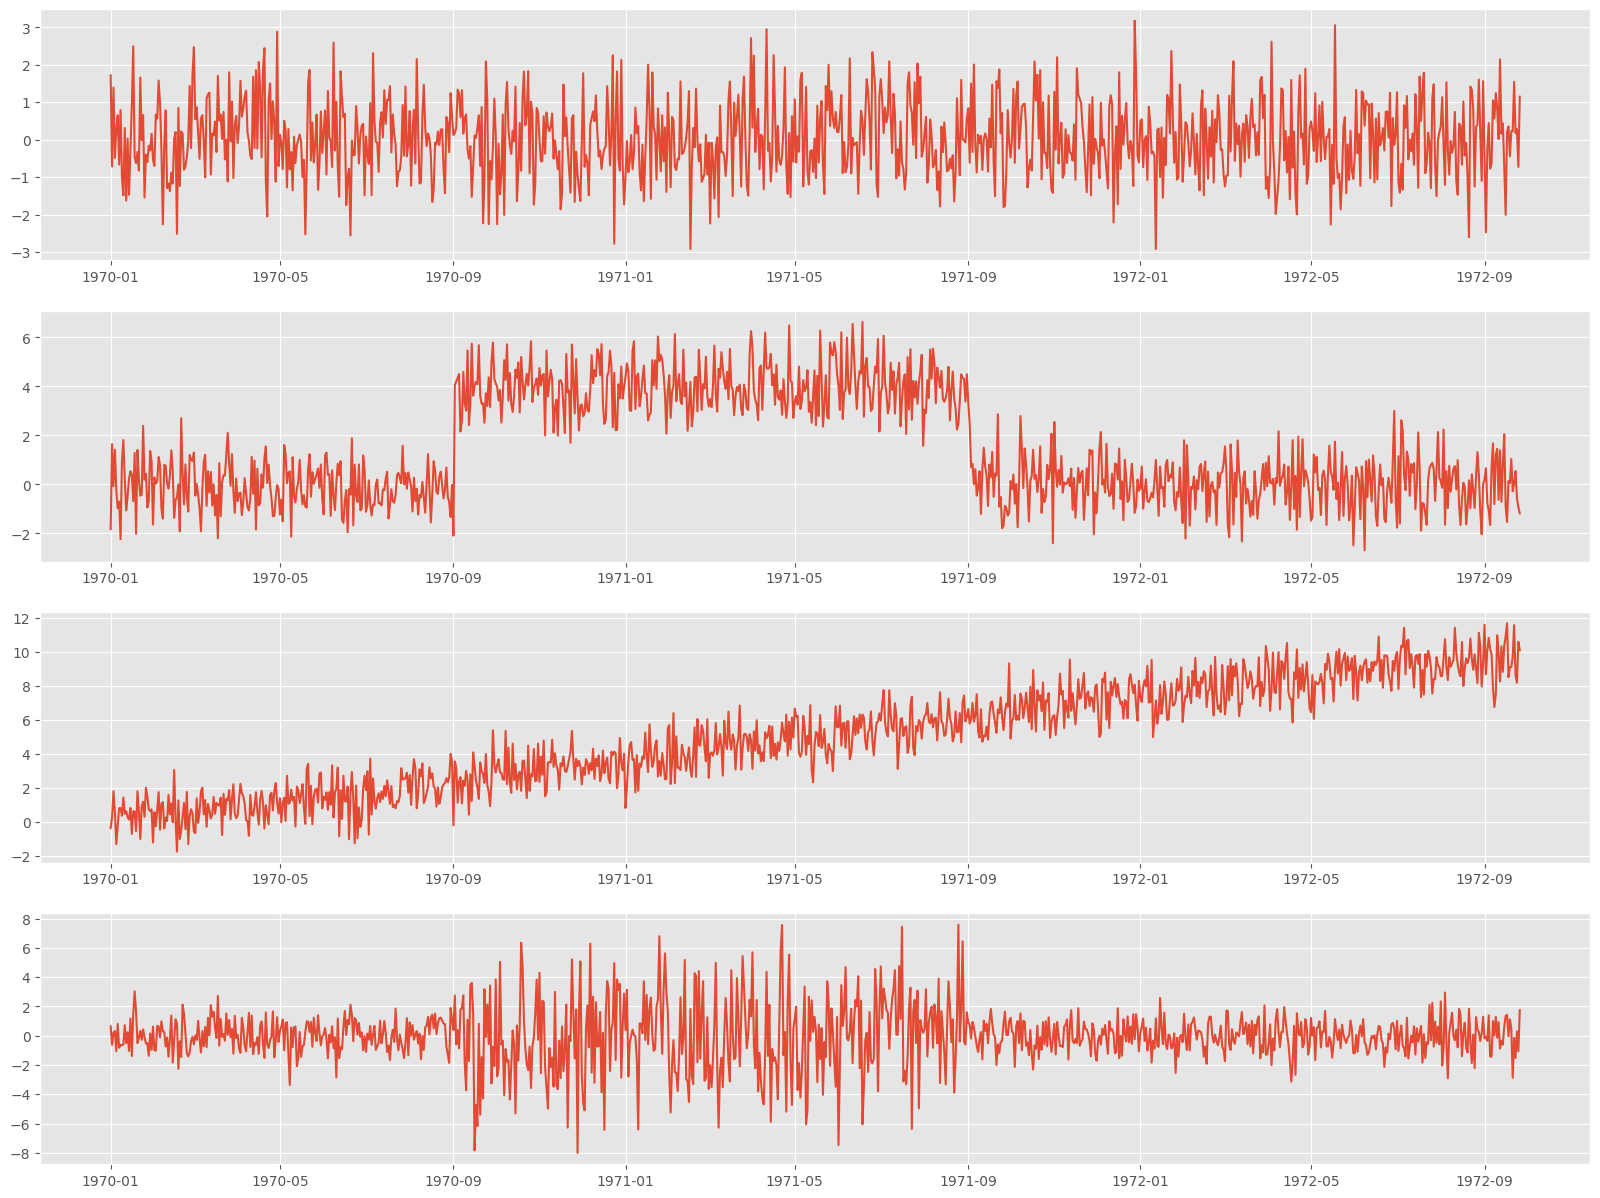

In [ ]:
n_sim = 1000
fig, ax = plt.subplots(nrows=4, figsize=(20,15))
index = pd.date_range(start='01.01.1970', periods=n_sim, freq='D')

ax[0].plot(pd.Series(np.random.normal(size=n_sim), index=index))

ax[1].plot(pd.Series(
    np.random.normal(size=n_sim) +
    (index > '1970-09') * 4 -
    (index > '1971-09') * 4,
    index=index))

ax[2].plot(pd.Series(np.random.normal(size=n_sim) + np.arange(n_sim)/100, index=index))

ax[3].plot(pd.Series(
    np.random.normal(scale=1 +
    (index > '1970-09') * 2 -
    (index > '1971-09') * 2, size=n_sim) ,
    index=index))

## **<font color='green' size=5> Корреляция**


💡 ACF (Autocorrelation Function)
ACF измеряет корреляцию между временным рядом и его лагированными (запаздывающими) значениями.

Лаг - это количество временных единиц между текущим моментом времени и моментом времени, когда было измерено предыдущее значение.

ACF находит корреляции для различных лагов и позволяет определить структуру временного ряда. Если ACF значительно отличается от нуля при определенном лаге, это может указывать на наличие зависимости в данных на этом лаге.

 Автокорреляционная функция вычисляется по формуле:

$$\rho_{k} = {ACF}(k) =\frac{cov(Y_t,Y_{t-k})}{var(Y_t)}=
\frac{\sum_{t=k+1}^{n}(y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^{n}(y_t - \bar{y})^2}$$




💡 PACF (partial autocorrelation function) частная автокорреляционная функция.

Смысл: PACF мерит на сколько изменится $y_t$ при изменении $y_{t-k}$ при условии что остальные лаги $y_{t-m}$, где $ m<k$  будут константами

PACF(k) – «чистая корреляция» между $y_t$ и $y_{t-k}$ при исключении влияния $y_{t-1},...,y_{t-k+1}$
PACF(k) вычисляется как МНК оценка коэффициента $β_k$ в регрессии. Для каждого значения PACF(k) строится своя регрессия.




$y_t = \beta_0 + \beta_1 y_{t-1}+ \beta_2 y_{t-2} + ... +  \beta_k y_{t-k} + \epsilon_{t}$

## **<font color='green' size=5> Примеры**

### Белый шум

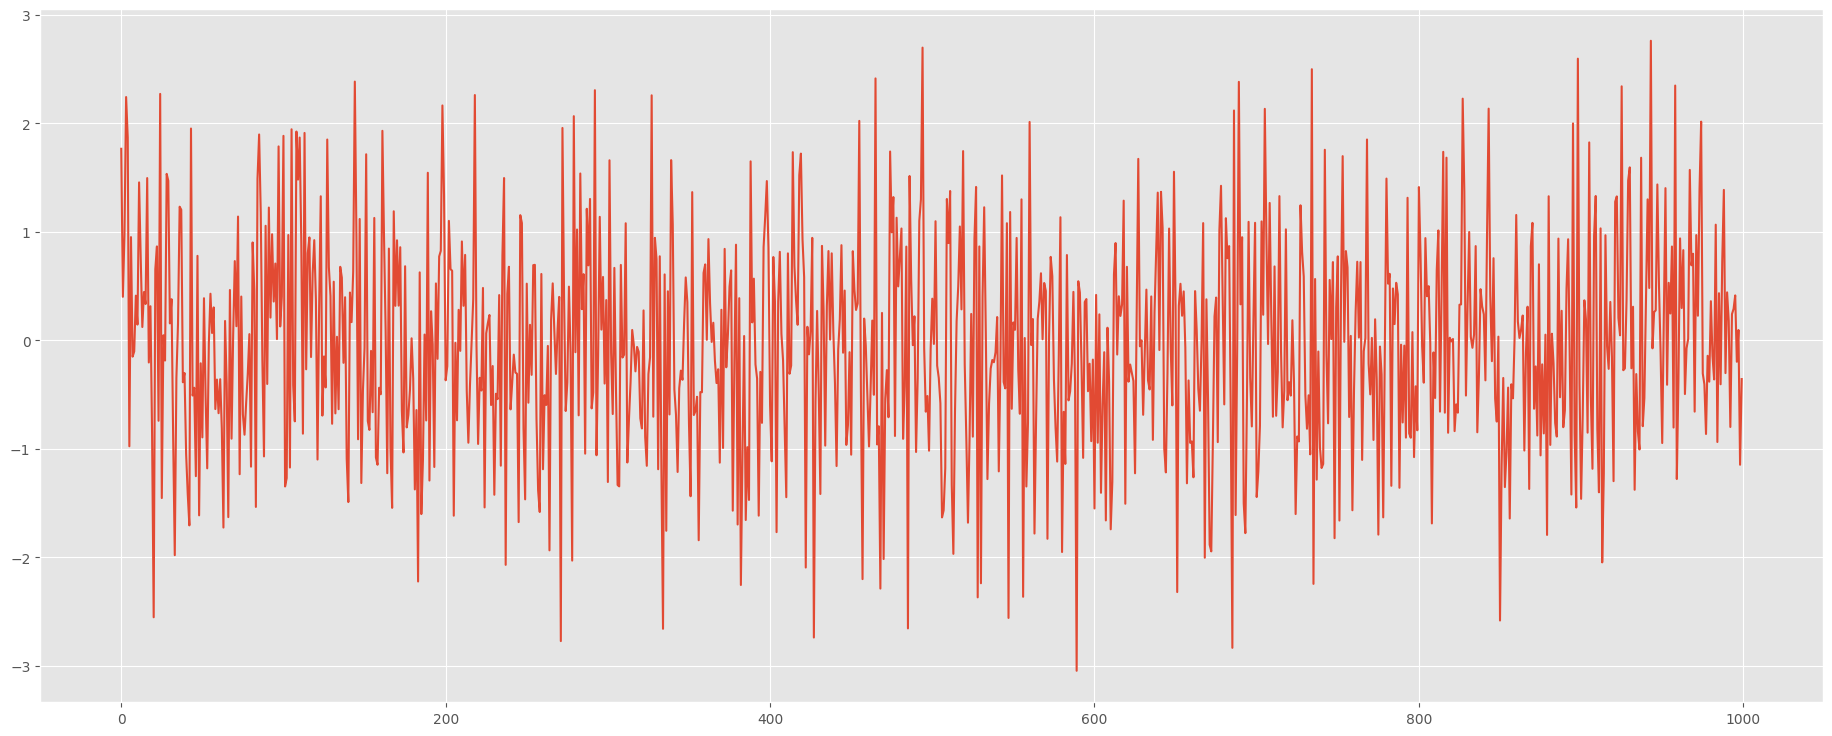

In [ ]:
# Создаем белый шум (1000 точек)
n_obs = 1000
np.random.seed(0)
white_noise = np.random.normal(loc=0, scale=1, size=n_obs)
plt.plot(white_noise)
plt.show()

In [ ]:

# Проверяем стационарность с помощью теста Дики-Фуллера
result = adfuller(white_noise)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])


ADF Statistic: -32.462559337689974
p-value: 0.0
Critical Values: {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}


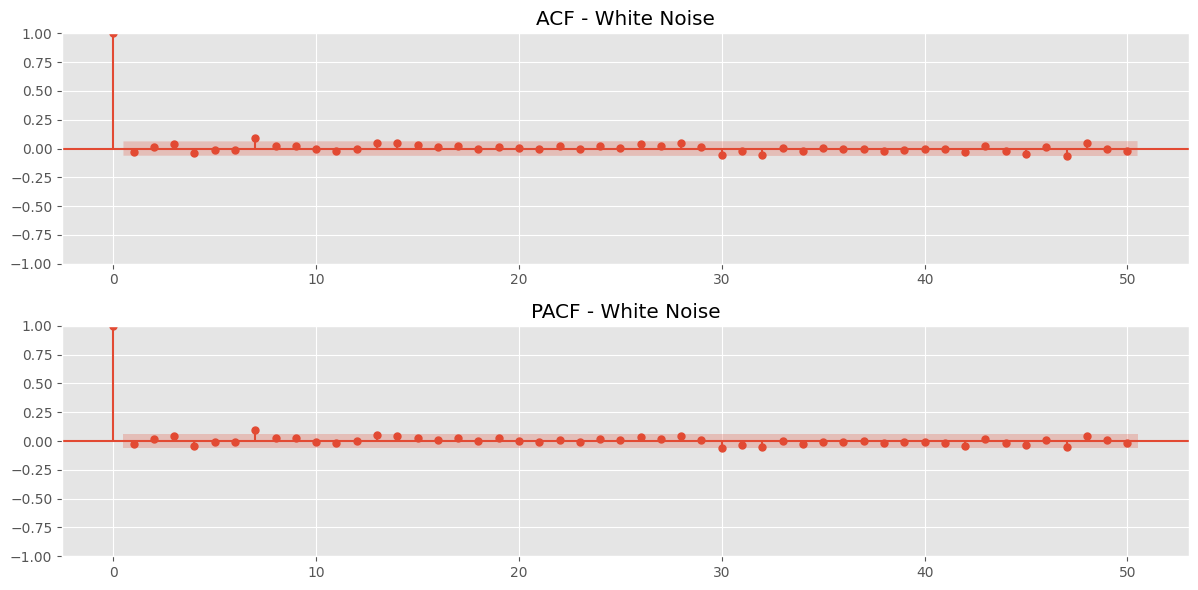

In [ ]:

# Построение PACF и ACF
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(white_noise, lags=50, ax=plt.gca(), title='ACF - White Noise')
plt.subplot(2, 1, 2)
plot_pacf(white_noise, lags=50, ax=plt.gca(), title='PACF - White Noise')
plt.tight_layout()
plt.show()


### random walk

$y_t = y_{t-1} + e_t$


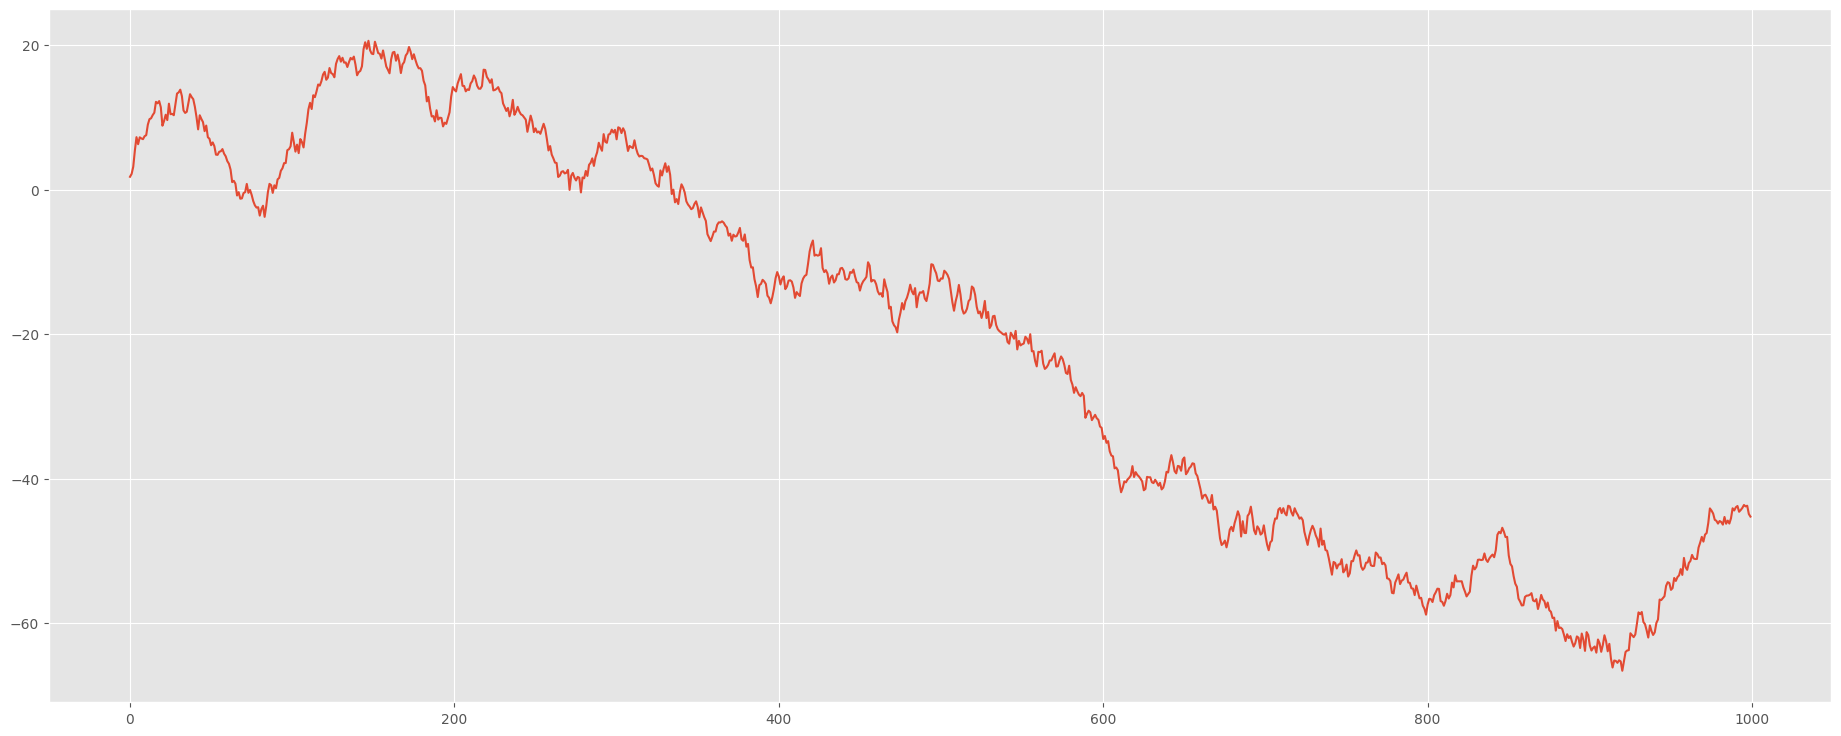

In [ ]:
# Создаем случайное блуждание (1000 точек)
np.random.seed(0)  # Для воспроизводимости результатов
random_walk = np.cumsum(np.random.normal(loc=0, scale=1, size=1000))
plt.plot(random_walk)
plt.show()

In [ ]:

# Проверяем стационарность с помощью теста Дики-Фуллера
result = adfuller(random_walk)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])


ADF Statistic: -0.5437433594783736
p-value: 0.8831939389121154
Critical Values: {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}


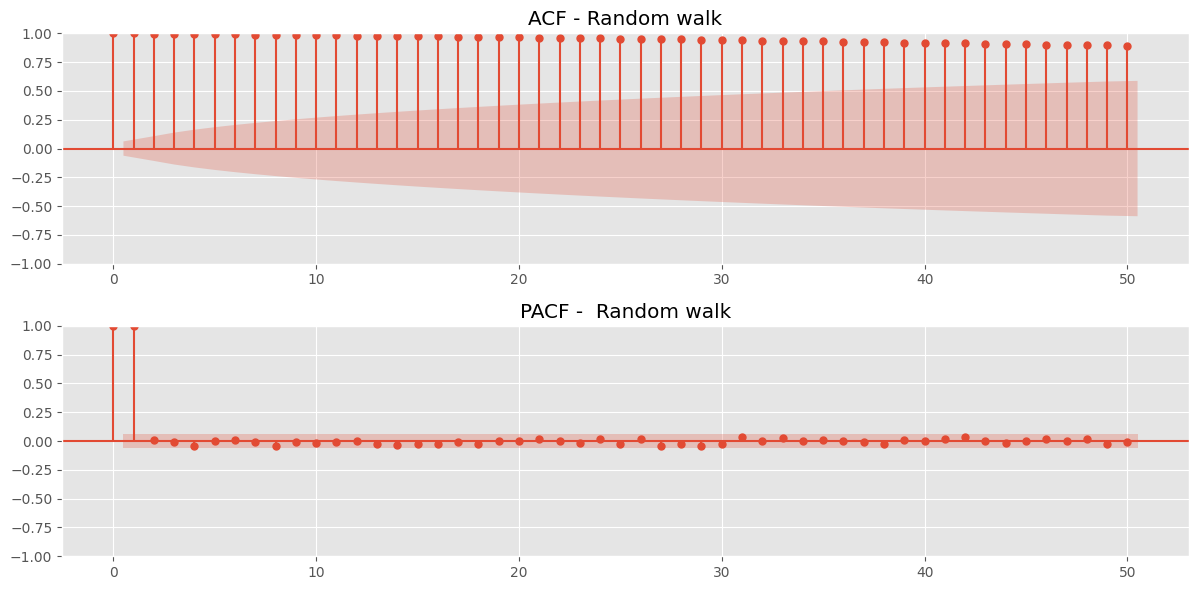

In [ ]:

# Построение PACF и ACF
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(random_walk, lags=50, ax=plt.gca(), title='ACF - Random walk')
plt.subplot(2, 1, 2)
plot_pacf(random_walk, lags=50, ax=plt.gca(), title='PACF -  Random walk')
plt.tight_layout()
plt.show()


Очень медленно затухает ACF - это признак случайного блуждания

### для процесса с трендом

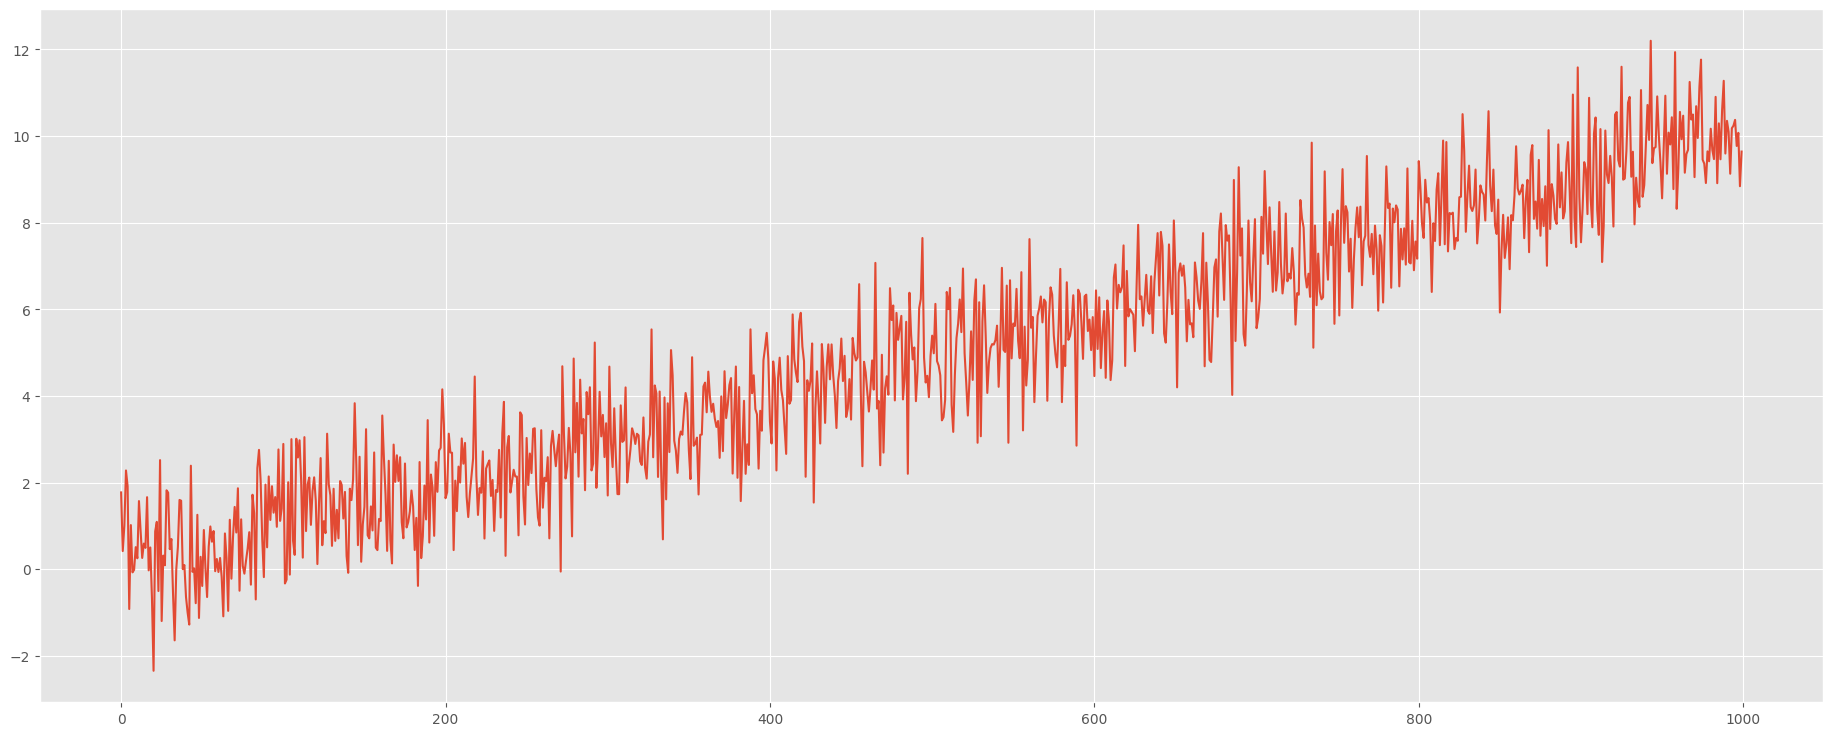

In [ ]:
# Создаем временной ряд с трендом
np.random.seed(0)
t = np.arange(1, 1001)
mu = 0.01  # Коэффициент тренда
trend = mu * t
epsilon = np.random.normal(loc=0, scale=1, size=1000)  # Случайные ошибки
time_series_with_trend = trend + epsilon
plt.plot(time_series_with_trend)
plt.show()

In [ ]:

# Проверяем стационарность с помощью теста Дики-Фуллера
result = adfuller(time_series_with_trend)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])


ADF Statistic: -0.1561311017106812
p-value: 0.9435526441669879
Critical Values: {'1%': -3.4370334797663844, '5%': -2.8644907213150725, '10%': -2.568341114581742}


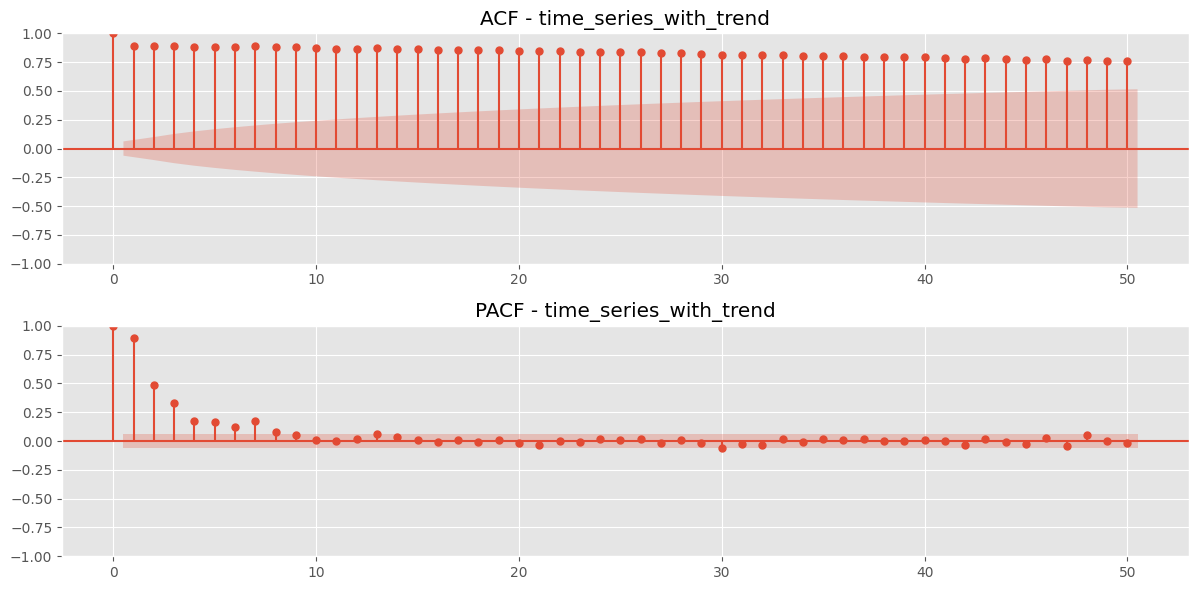

In [ ]:

# Построение PACF и ACF
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(time_series_with_trend, lags=50, ax=plt.gca(), title='ACF - time_series_with_trend')
plt.subplot(2, 1, 2)
plot_pacf(time_series_with_trend, lags=50, ax=plt.gca(), title='PACF - time_series_with_trend')
plt.tight_layout()
plt.show()


### AR(1)
$$X_t = \phi X_{t-1} + \epsilon_t$$


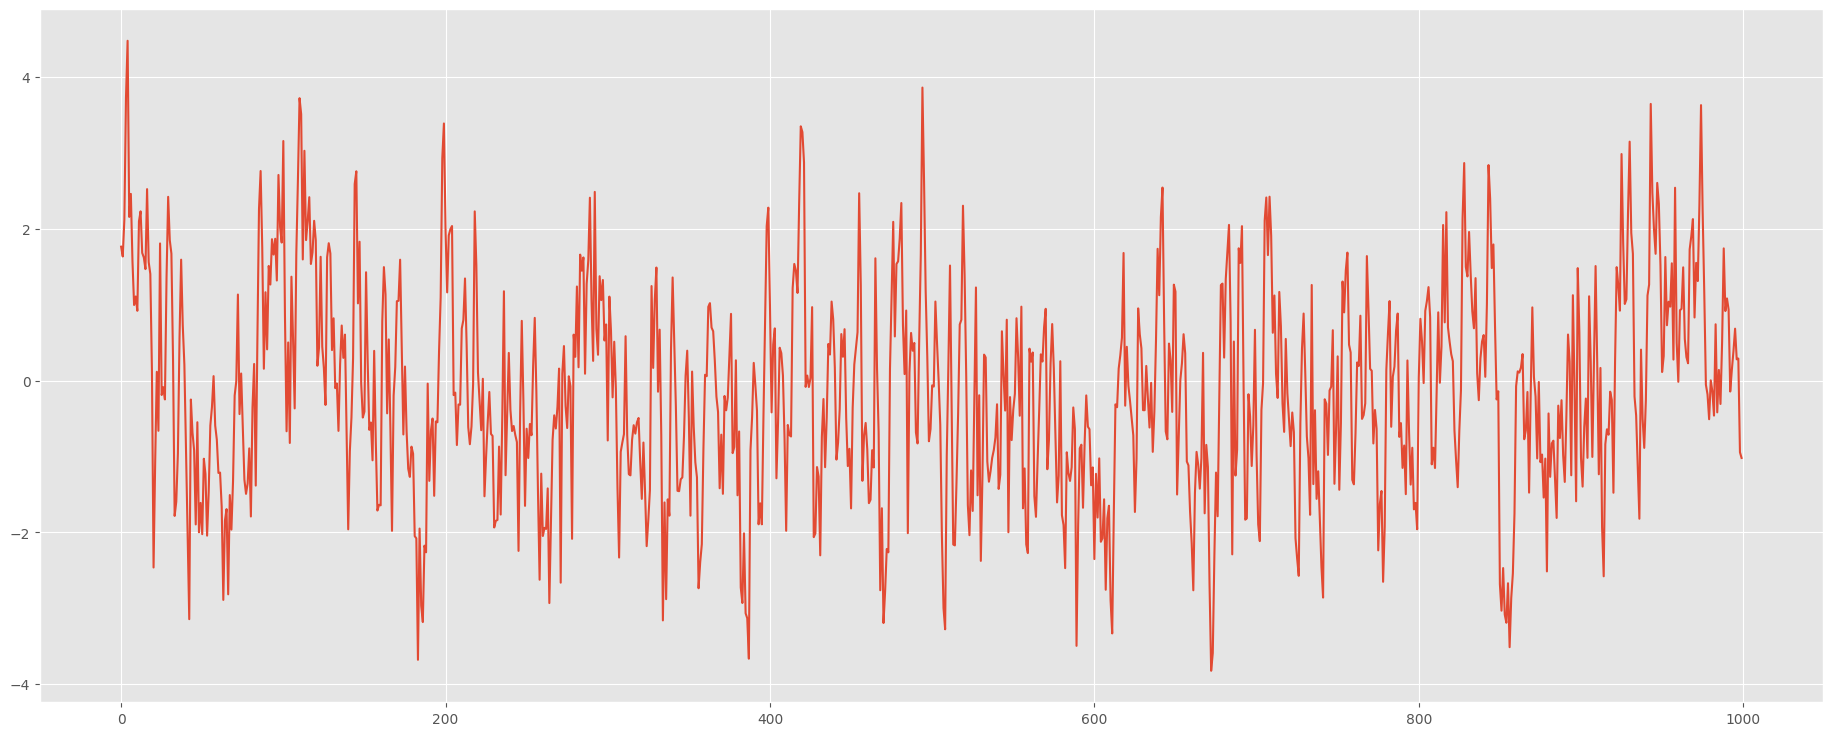

In [ ]:
#  Создаем AR(1) временной ряд
np.random.seed(0)  # Для воспроизводимости результатов
N = 1
phi = 0.7  # Параметр авторегрессии
errors = np.random.normal(loc=0, scale=1, size=1000)  # Случайные ошибки

ar_process = [errors[0]]  # Начальное значение ряда

for i in range(1, len(errors)):
    ar_process.append(phi * ar_process[i - N] + errors[i])
ar_process = np.array(ar_process)

plt.plot(ar_process)
plt.show()

In [ ]:

# Проверяем стационарность с помощью теста Дики-Фуллера
result = adfuller(ar_process)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])


ADF Statistic: -8.013981850615377
p-value: 2.16352296146365e-12
Critical Values: {'1%': -3.4369525024039884, '5%': -2.8644550095200705, '10%': -2.568322093455802}


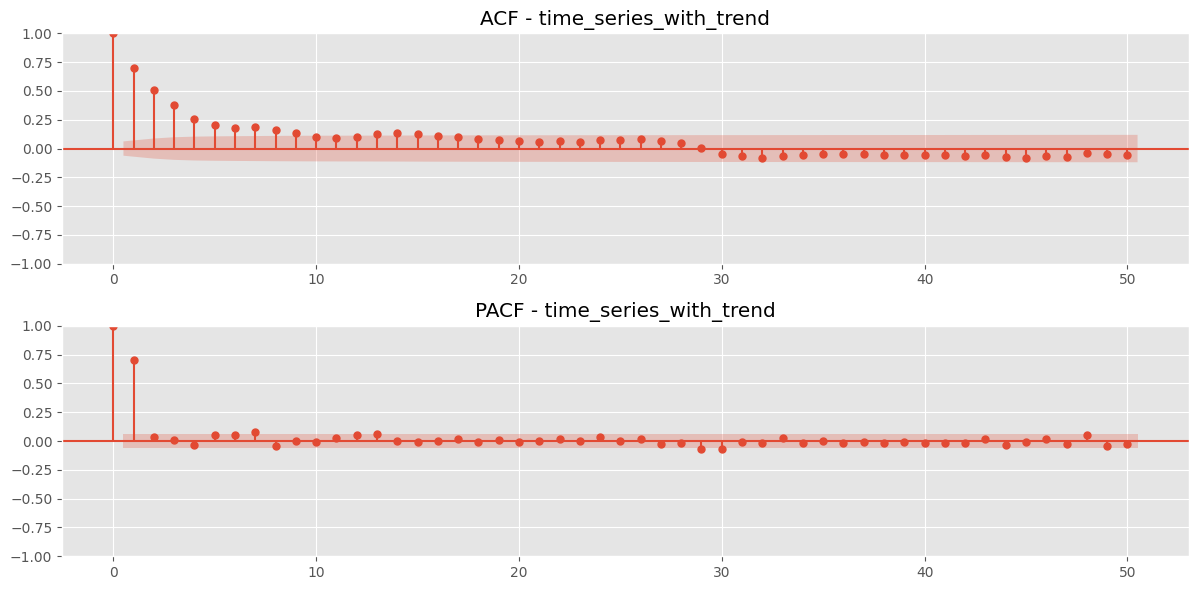

In [ ]:

# Построение PACF и ACF
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(ar_process, lags=50, ax=plt.gca(), title='ACF - time_series_with_trend')
plt.subplot(2, 1, 2)
plot_pacf(ar_process, lags=50, ax=plt.gca(), title='PACF - time_series_with_trend')
plt.tight_layout()
plt.show()


Если в графике функции автокорреляции частичных коэффициентов (PACF) ярко выделяются пики, это может свидетельствовать о наличии авторегрессионной (AR) компоненты в модели временных рядов.

### MA(1)

В MA(1) значение временного ряда в текущий момент времени зависит от текущей ошибки и ошибки в предыдущий момент времени.

$$X_t = \mu + \epsilon_t + \theta \epsilon_{t-1}
$$

In [ ]:
# Создаем MA(1) временной ряд
np.random.seed(0)  # Для воспроизводимости результатов
N = 3
theta = 0.9  # Параметр MA(1)
errors = np.random.normal(loc=0, scale=1, size=1000)  # Случайные ошибки

ma_process = [errors[0]]  # Начальное значение ряда
ma_process

[1.764052345967664]

In [ ]:
for i in range(1, len(errors)):
    ma_process.append(errors[i] + theta * errors[i - N])
ma_process = np.array(ma_process)

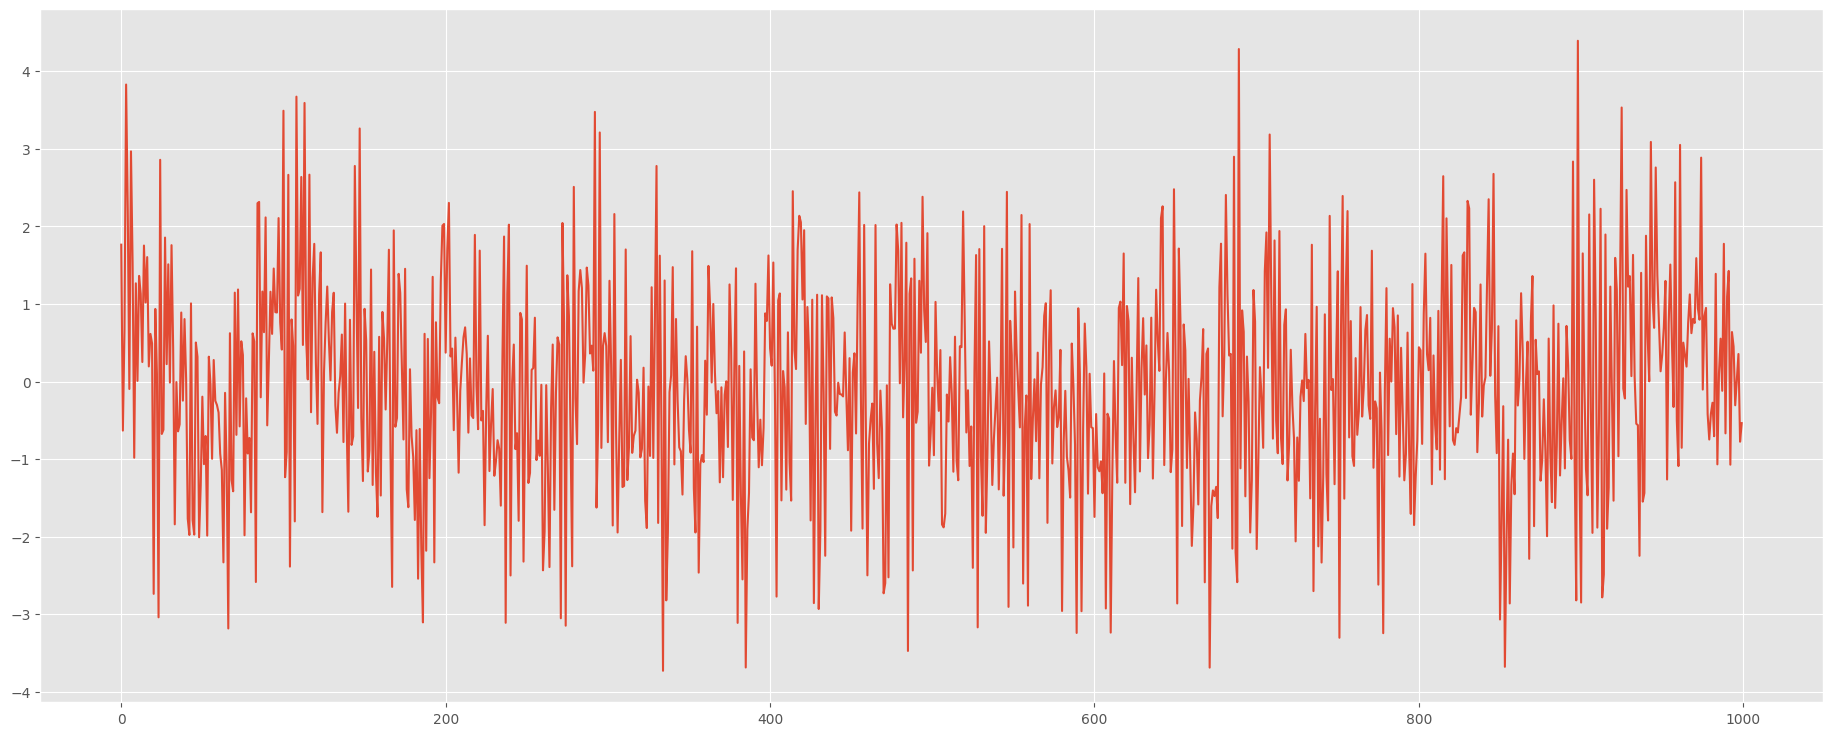

In [ ]:
plt.plot(ma_process)
plt.show()

In [ ]:

# Проверяем стационарность с помощью теста Дики-Фуллера
result = adfuller(ma_process)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])


ADF Statistic: -4.986776694070289
p-value: 2.357008472554957e-05
Critical Values: {'1%': -3.4370471695043037, '5%': -2.8644967585264784, '10%': -2.5683443301882956}


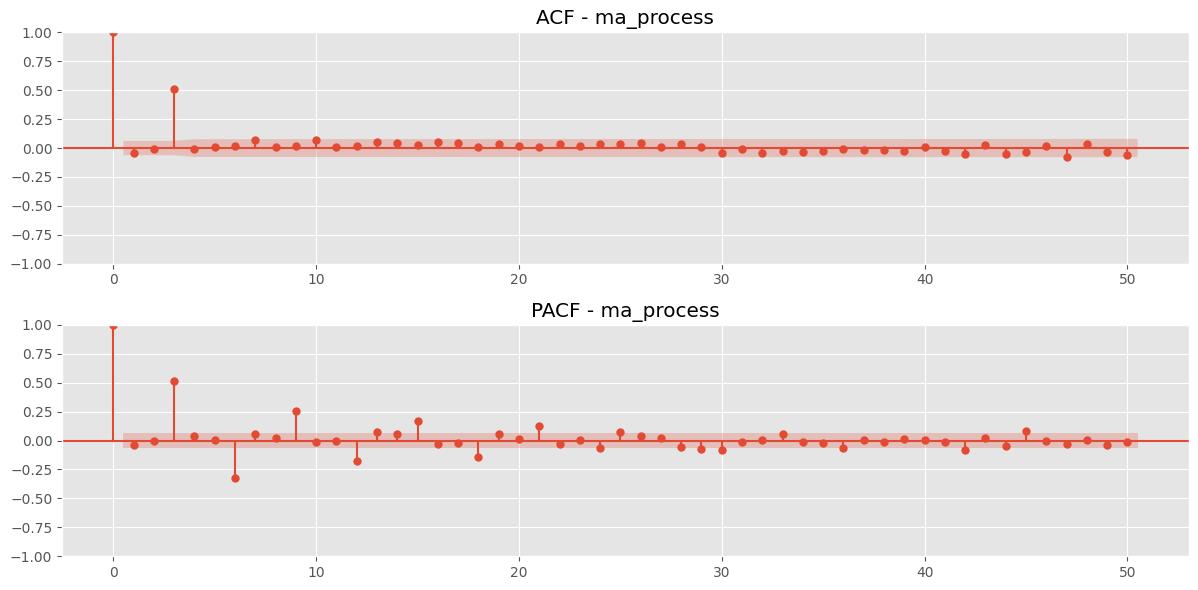

In [ ]:

# Построение PACF и ACF
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(ma_process, lags=50, ax=plt.gca(), title='ACF - ma_process')
plt.subplot(2, 1, 2)
plot_pacf(ma_process, lags=50, ax=plt.gca(), title='PACF - ma_process')
plt.tight_layout()
plt.show()


## Вывод:
 - разумнее PACF и ACF строить для слабо стационарных рядов

- Если ряд нестационарный ---> необходимо его привести к стационарному

- по PACF и ACF определяют параметры ARMA(p,q). Если ярко выражен PACF ---> значит в модели есть AR составляющяя соотвествующего порядка,
если ярко выражена ACF ---> значит в модели есть MA составляющая соответствующего порядка

# **<font color='green' size=6> Pandas for time series**

In [ ]:
# Загружаем данные

df = sns.load_dataset('flights')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [ ]:
df.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [ ]:
df[['year', 'month']] = df[['year', 'month']].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        144 non-null    object
 1   month       144 non-null    object
 2   passengers  144 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.5+ KB


In [ ]:
df['date'] = df['year'] + "-" + df["month"]

# df["date_2"] = df[["year", "month"]].apply("-".join, axis=1)
# df["date_3"] = df["year"].str.cat(df["month"], sep="-")


df.head()

,year,month,passengers,date
0,1949,Jan,112,1949-Jan
1,1949,Feb,118,1949-Feb
2,1949,Mar,132,1949-Mar
3,1949,Apr,129,1949-Apr
4,1949,May,121,1949-May


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.head()

<ipython-input-125-4ff7c850c9b1>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


,year,month,passengers,date
0,1949,Jan,112,1949-01-01
1,1949,Feb,118,1949-02-01
2,1949,Mar,132,1949-03-01
3,1949,Apr,129,1949-04-01
4,1949,May,121,1949-05-01


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year        144 non-null    object        
 1   month       144 non-null    object        
 2   passengers  144 non-null    int64         
 3   date        144 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.6+ KB


In [ ]:
df = df.set_index(df.date)
df.head()

,year,month,passengers,date
date,,,,
1949-01-01,1949,Jan,112,1949-01-01
1949-02-01,1949,Feb,118,1949-02-01
1949-03-01,1949,Mar,132,1949-03-01
1949-04-01,1949,Apr,129,1949-04-01
1949-05-01,1949,May,121,1949-05-01


In [ ]:
df = df.drop(columns=['year', 'month', 'date'])
df.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


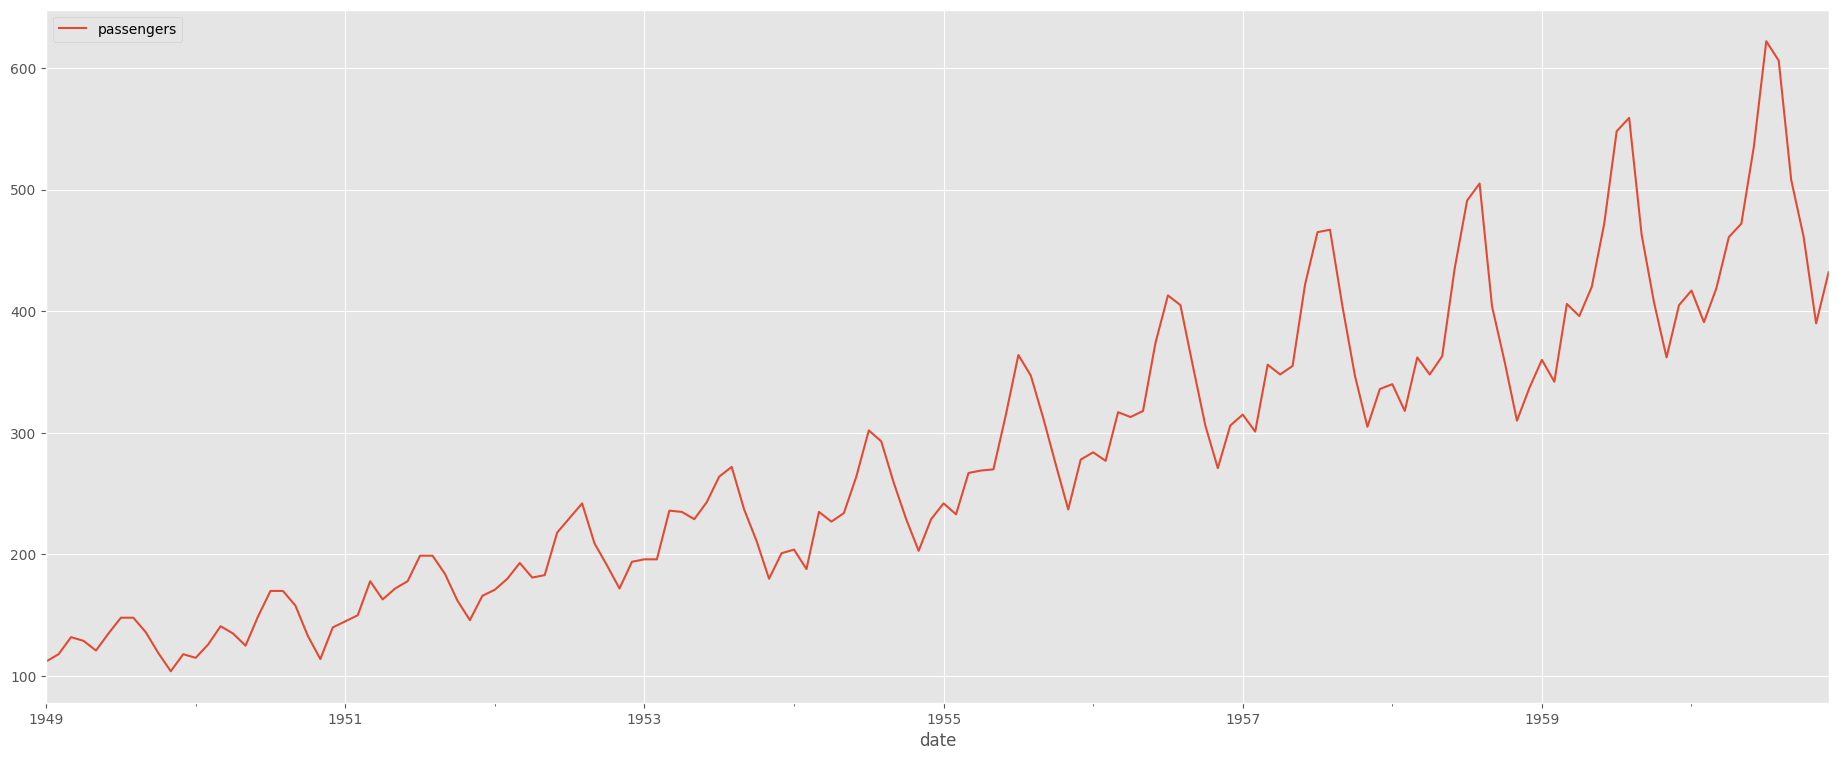

In [ ]:
_ = df.plot()

## Pandas time series indexing


### Преимущества индекстов в виде datetime

* срезы по датам, годам, месяцам...
* вместо group_by == resample

In [ ]:
df.index.weekday

Index([5, 1, 1, 4, 6, 2, 4, 0, 3, 5,
       ...
       1, 4, 6, 2, 4, 0, 3, 5, 1, 3],
      dtype='int32', name='date', length=144)

In [ ]:
# df.index

In [ ]:
df['1949':'1950']

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [ ]:
df['1949-06':'1950-6']

,passengers
date,
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136
1949-10-01,119
1949-11-01,104
1949-12-01,118
1950-01-01,115
1950-02-01,126


In [ ]:
df.resample('M').sum()

,passengers
date,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
...,...
1960-08-31,606
1960-09-30,508
1960-10-31,461


In [ ]:
df.resample('Y')

In [ ]:
df.resample('Y').mean()

,passengers
date,
1949-12-31,126.666667
1950-12-31,139.666667
1951-12-31,170.166667
1952-12-31,197.000000
1953-12-31,225.000000
1954-12-31,238.916667
1955-12-31,284.000000
1956-12-31,328.250000
1957-12-31,368.416667


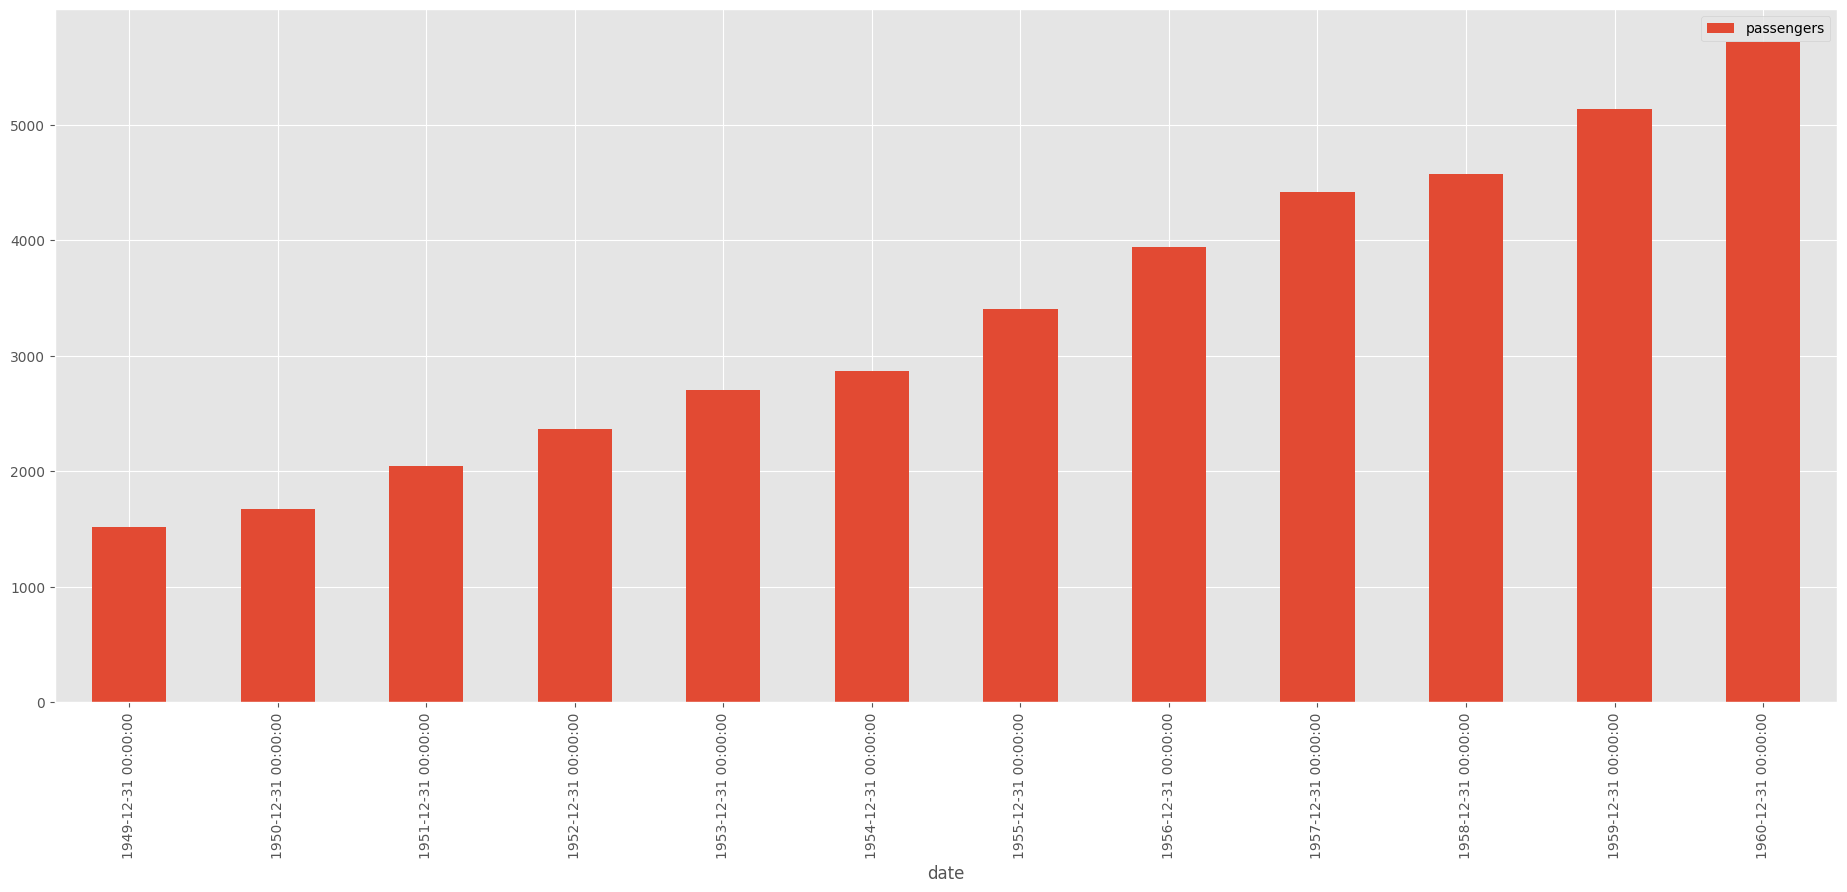

In [ ]:
_ = df.resample('Y').sum().plot(kind='bar')

## Rolling window

* скользящее окно,
* скользящее среднее - похоже на оконную функцию в SQL
* фильтруем шум, сезонность и тренды

<Axes: xlabel='date'>

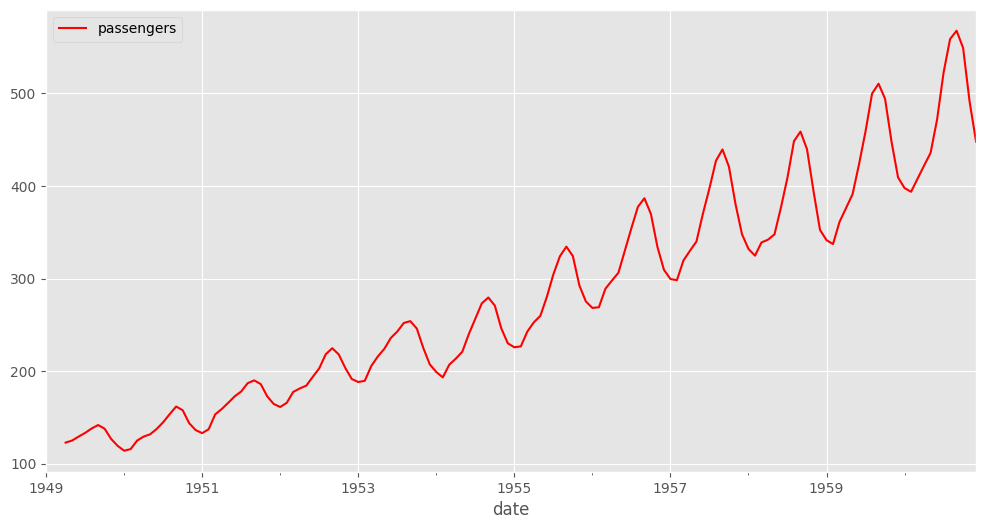

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

df.rolling(window=4).mean().plot(c='red', ax=ax)

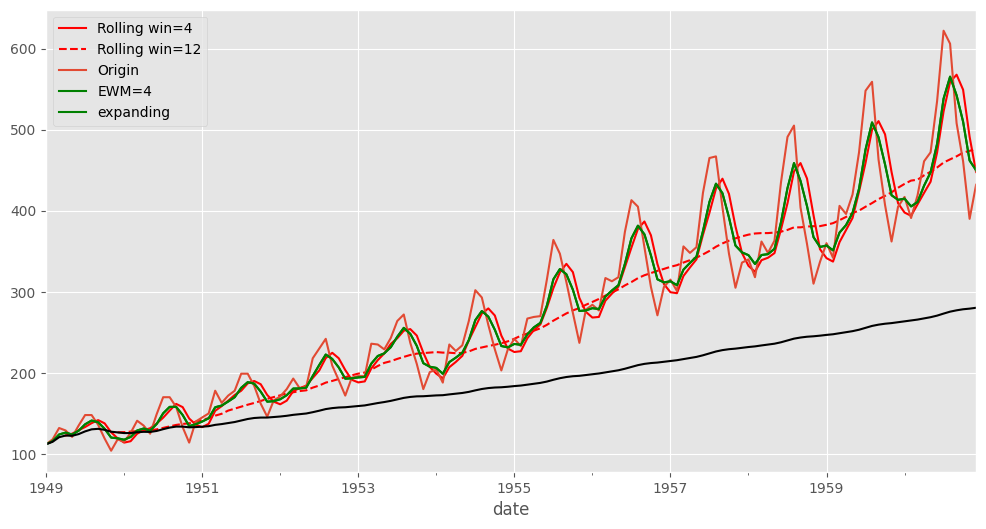

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

df.rolling(window=4).mean().plot(c='red', ax=ax)
df.rolling(window=12).mean().plot(c='red', style='--', ax=ax)
df.plot(label='Original', ax=ax)
# используется для вычисления экспоненциального скользящего среднего и построения графика.
df.ewm(span=4).mean().plot(label='EWM=4', c='green', ax=ax, )

df.ewm(span=4).mean().plot(label='EWM=4', c='green', ax=ax, )

# https://pandas.pydata.org/pandas-docs/stable/user_guide/window.html#expanding-window
# df.expanding()

df.expanding(min_periods=1).mean().plot(c='black', ax=ax)

_ = ax.legend(['Rolling win=4','Rolling win=12', 'Origin', "EWM=4", "expanding" ])

Полезно уметь делать датасет с диапазоном дат без данных

In [ ]:
pd.date_range('1961-01-01', '1962-12', freq='MS')

DatetimeIndex(['1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01',
               '1961-05-01', '1961-06-01', '1961-07-01', '1961-08-01',
               '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
               '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01',
               '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01'],
              dtype='datetime64[ns]', freq='MS')

## Сдвиг и производная от графика

In [ ]:
df['passengers']

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: passengers, Length: 144, dtype: int64

In [ ]:
df['passengers'].shift(1).head() # по умолчанию сдвиг 1, можно брать отрицательные значения

date
1949-01-01      NaN
1949-02-01    112.0
1949-03-01    118.0
1949-04-01    132.0
1949-05-01    129.0
Name: passengers, dtype: float64

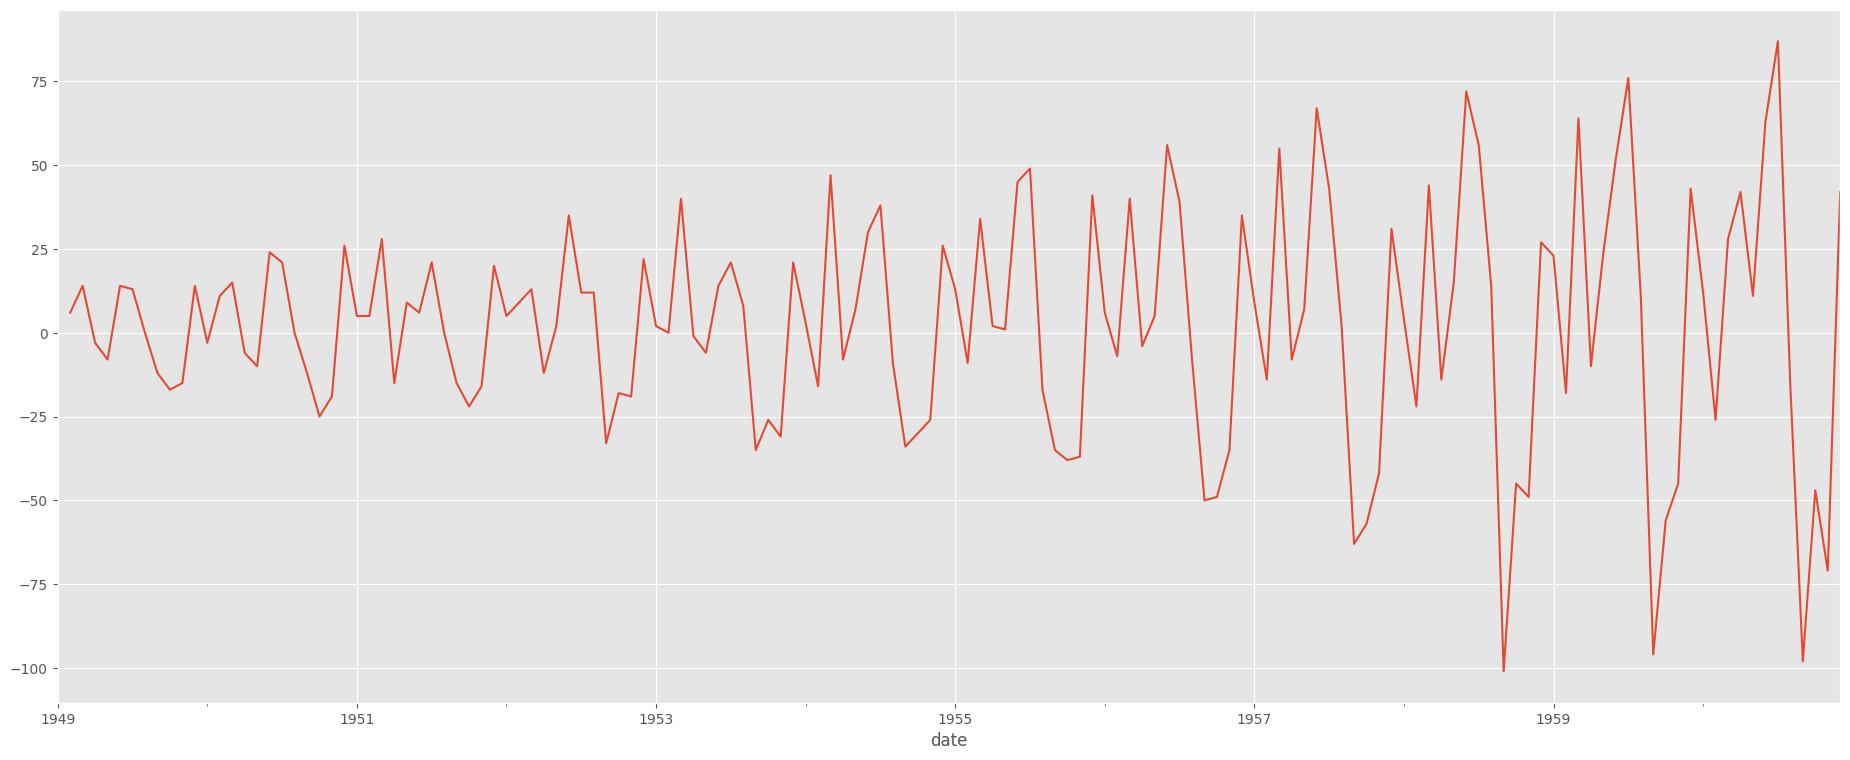

In [ ]:
_ = (df['passengers']-df['passengers'].shift(1)).plot()

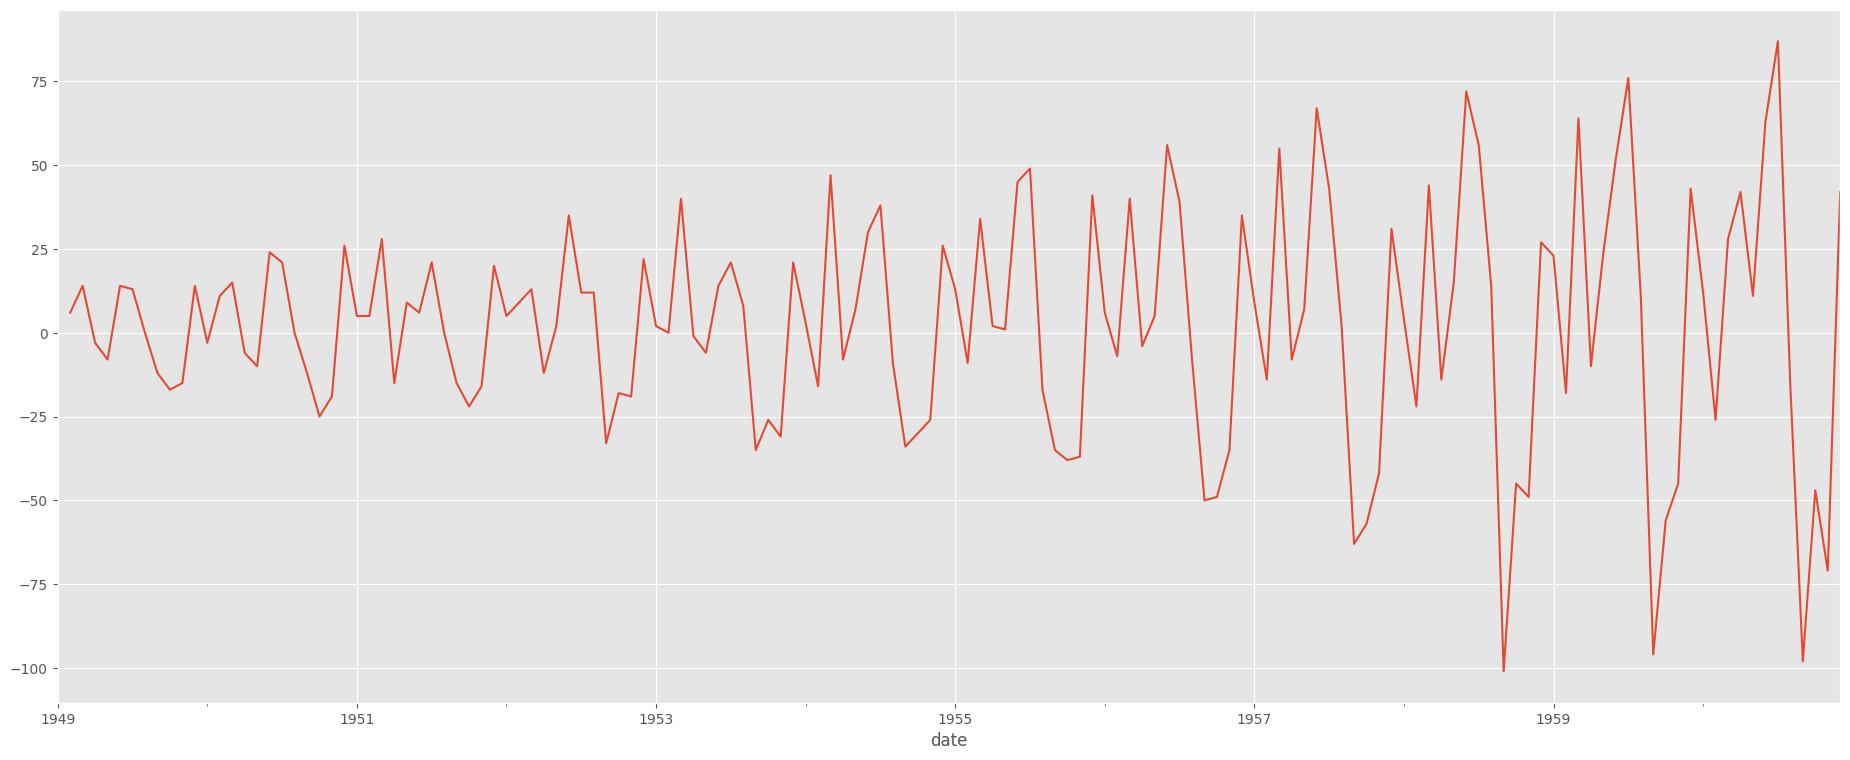

In [ ]:
_ = df['passengers'].diff(1).plot()

In [ ]:
df_copy = df.copy()

# **<font color='green' size=6>  Разделение на трейн и тест**

In [ ]:
# размер тестовой выборки
test_size = int(len(df) * 0.2)

# тренировочная выборка
train = df[:-test_size]

# тестовая выборка
test = df[-test_size-1:]

# **<font color='green' size=6> ARMA, ARIMA, SARIMA, SARIMAX**

Доки по прогнозированию в statsmodels  
https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_forecasting.html

 - `ARMA` (Autoregressive Moving Average) - модель, объединяющая авторегрессионную (AR) и модель скользящего среднего (MA) компоненты.  
 Используется для стационарных временных рядов без тренда и сезонности.

 - `ARIMA` (Autoregressive Integrated Moving Average) - расширение `ARMA`, которое включает дополнительную интегрированную (I) компоненту для обработки нестационарных рядов с трендом.  
 Применяется для нестационарных рядов после их предварительного приведения к стационарности путем взятия разностей.

 - `SARIMA` (Seasonal ARIMA) - сезонная версия `ARIMA`, которая учитывает периодические сезонные колебания в данных.  
 Используется для временных рядов с ярко выраженной сезонностью.

 - `SARIMAX` (Seasonal ARIMAX) - расширение `SARIMA`, которое включает дополнительные регрессионные переменные (X) для учета влияния внешних факторов на временной ряд.  
 Подходит для сложных моделей с сезонностью и экзогенными переменными.

## SARIMA

**S** - Seasonal

**AR** - Auto-Regressive

**I** - Integrated

**MA** - Moving Average


- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

**X** - with eXogenous factors

https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

**Плюсы:**
    
- высокая точность предсказания
- учитвыает тренд и сезонность (SARIMA)
- учитывает внешние факторы (SARIMAX)

**Минусы:**

- долго подбирать гиперпараметры
- нужно понимать что такое диффиренцирование, авторегрессия и проч.

## Pmdarima - Обучение модели с поиском параметров

Метод: Использует метод (grid search) для подбора параметров модели ARIMA.  
Критерии: Оценивает модели по AIC или BIC (чем ниже, тем лучше).  
Параметры: Ищет оптимальные значения p,q, а также сезонные параметры
P, D, Q и период s.  
Стационарность: Проверяет стационарность временного ряда перед подбором параметров.

In [ ]:
%%time

# инициализация модели и подбор параметров с помощью auto_arima
model_aa = auto_arima(
    train.dropna(),
    error_action='ignore',
    trace=True,
    suppress_warnings=True,
    maxiter=24,
    seasonal=True,  # есть ли сезонность в данных
    m=12,  # период сезонности
    )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=766.303, Time=2.64 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=765.723, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=764.756, Time=0.47 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=765.328, Time=0.83 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=764.138, Time=0.21 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=764.944, Time=0.93 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=766.619, Time=1.16 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=765.206, Time=0.36 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=762.550, Time=0.39 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=765.329, Time=0.74 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=765.510, Time=1.09 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=767.126, Time=1.80 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=764.631, Time=0.16 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=766.465, Time=0.32 sec
 ARIMA(1,1,2)(0,1,0)[12]         

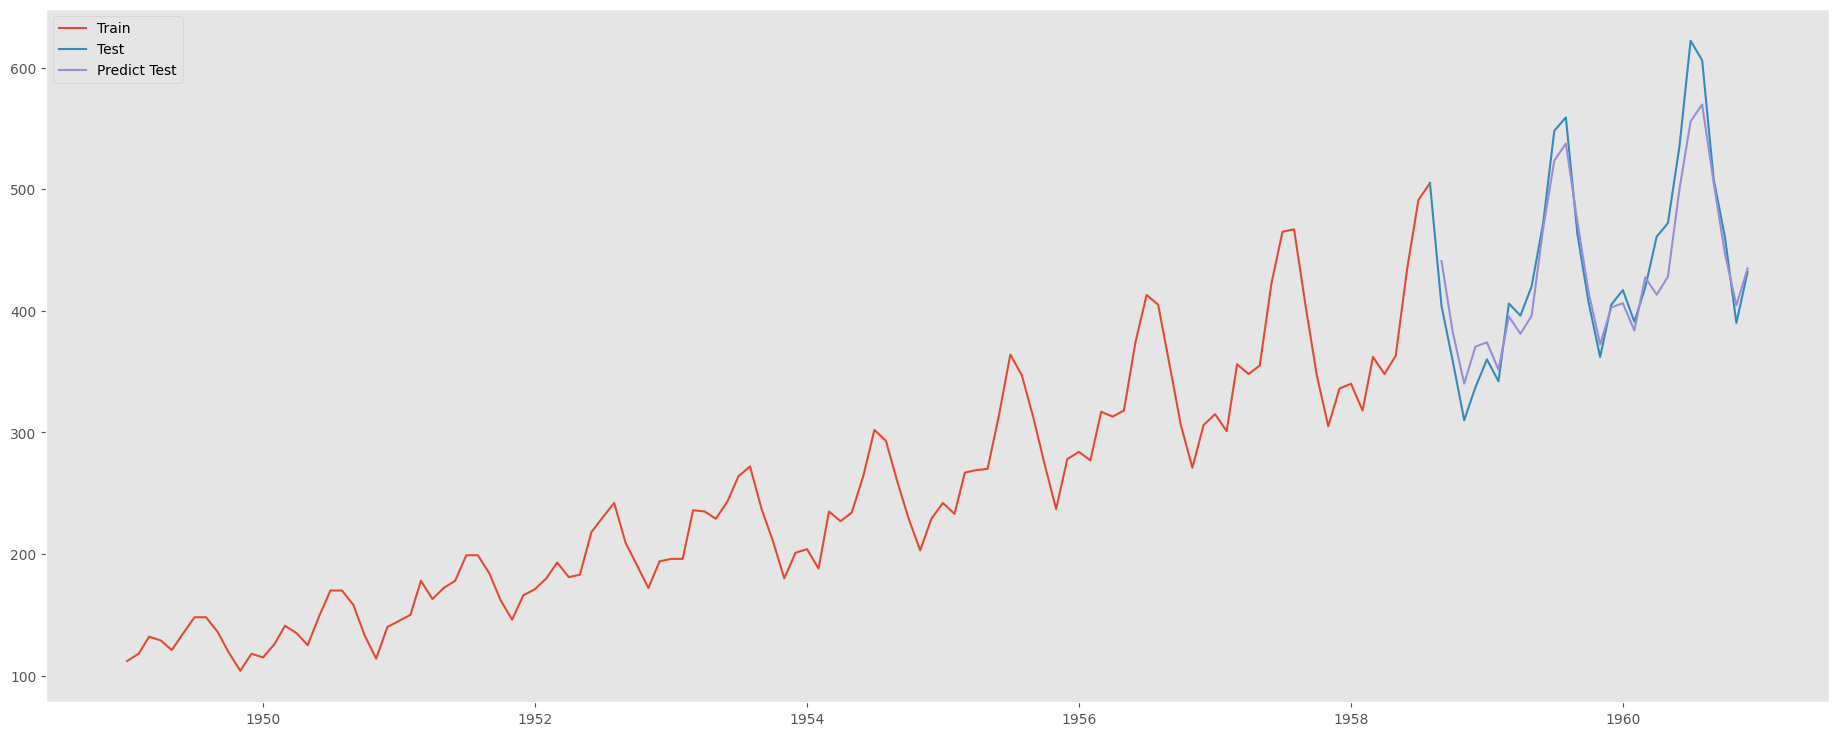

In [ ]:
# получение предсказаний
predict = model_aa.predict(n_periods=test_size)

# отрисовка обучающей выборки, тестовой и предсказанной тестовой
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predict, label='Predict Test')
plt.grid()
plt.legend()
plt.show()

In [ ]:
model_aa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  116
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -378.275
Date:                             Wed, 24 Jul 2024   AIC                            762.550
Time:                                     15:42:31   BIC                            770.454
Sample:                                 01-01-1949   HQIC                           765.752
                                      - 08-01-1958                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8014      0.081      9.916      0.000       0.643       0.960
ma.L1         -0.9731      0.045    -21.593      0.000      -1.061      -0.885
sigma2        89.8590     12.866      6.984      0.000      64.642     115.076
===================================================================================
Ljung-Box (L1) (Q):                   1.00   Jarque-Bera (JB):                 1.95
Prob(Q):                              0.32   Prob(JB):                         0.38
Heteroskedasticity (H):               0.87   Skew:                             0.32
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model: SARIMAX(1, 1, 1)x(0, 1, [], 12) - параметры модели:

ARIMA(1, 1, 1) - модель авторегрессии (AR) порядка 1, интегрированная (I) порядок 1 и скользящего среднего (MA) порядка 1.


(0, 1, [], 12) - сезонный компонент с порядком 0 для AR, порядком 1 для I, и порядком 0 для MA, с сезонностью в 12 периодов (например, месяцы в годовом цикле).


Heteroskedasticity (H): 0.87 - тест на гетероскедастичность (разную дисперсию остатков).

Prob(H) (two-sided): 0.68 - p-значение для теста. Значение больше 0.05 указывает на отсутствие гетероскедастичности.



# **<font color='green' size=6> Разделение на компоненты**

## **<font color='green' size=5> Seasonal_decompose**

In [ ]:
data = df.reset_index()
data.columns = ["date", "value"]
data = data.set_index(['date'])

In [ ]:
data

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


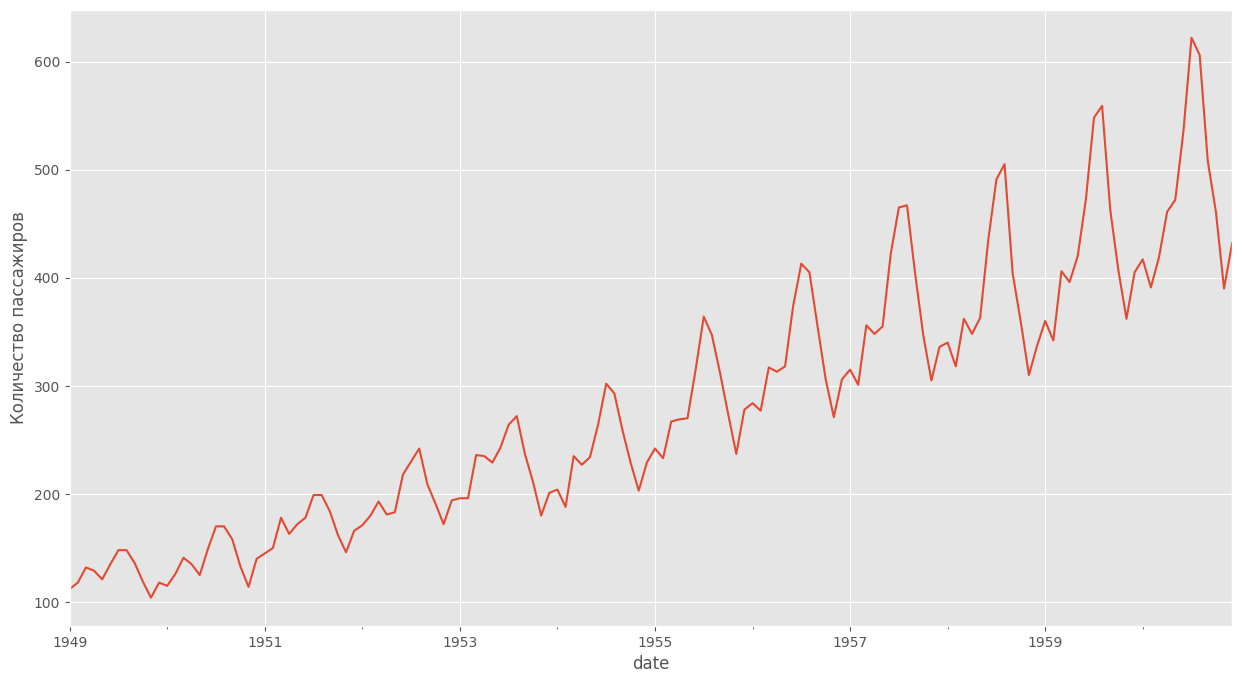

In [ ]:
plt.figure(figsize=(15,8))
data['value'].plot()
plt.ylabel('Количество пассажиров')
plt.show()

<Figure size 1500x800 with 0 Axes>

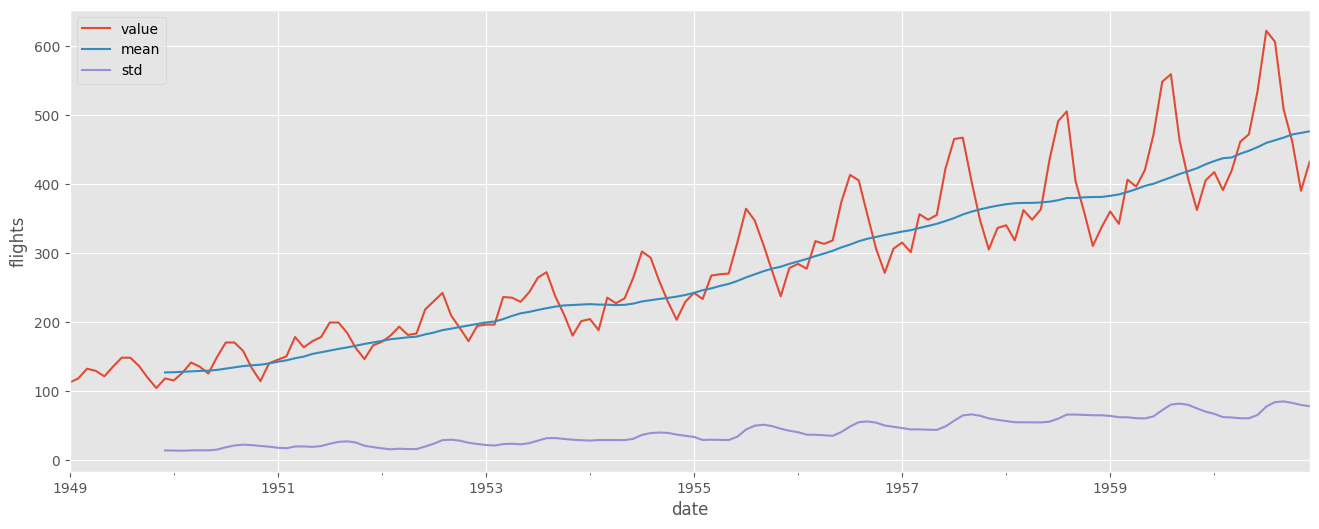

In [ ]:
plt.figure(figsize=(15,8))
data['mean'] = data['value'].rolling(12).mean()
data['std'] = data['value'].rolling(12).std()
data.plot(figsize=(16, 6))
plt.ylabel('flights')
plt.show()

`sm.tsa.seasonal_decompose` автоматически вычисляет тренд и сезонность, используя методы, такие как скользящее среднее для тренда и средние сезонные значения для сезонности, и предоставляет их в виде графиков для дальнейшего анализа.

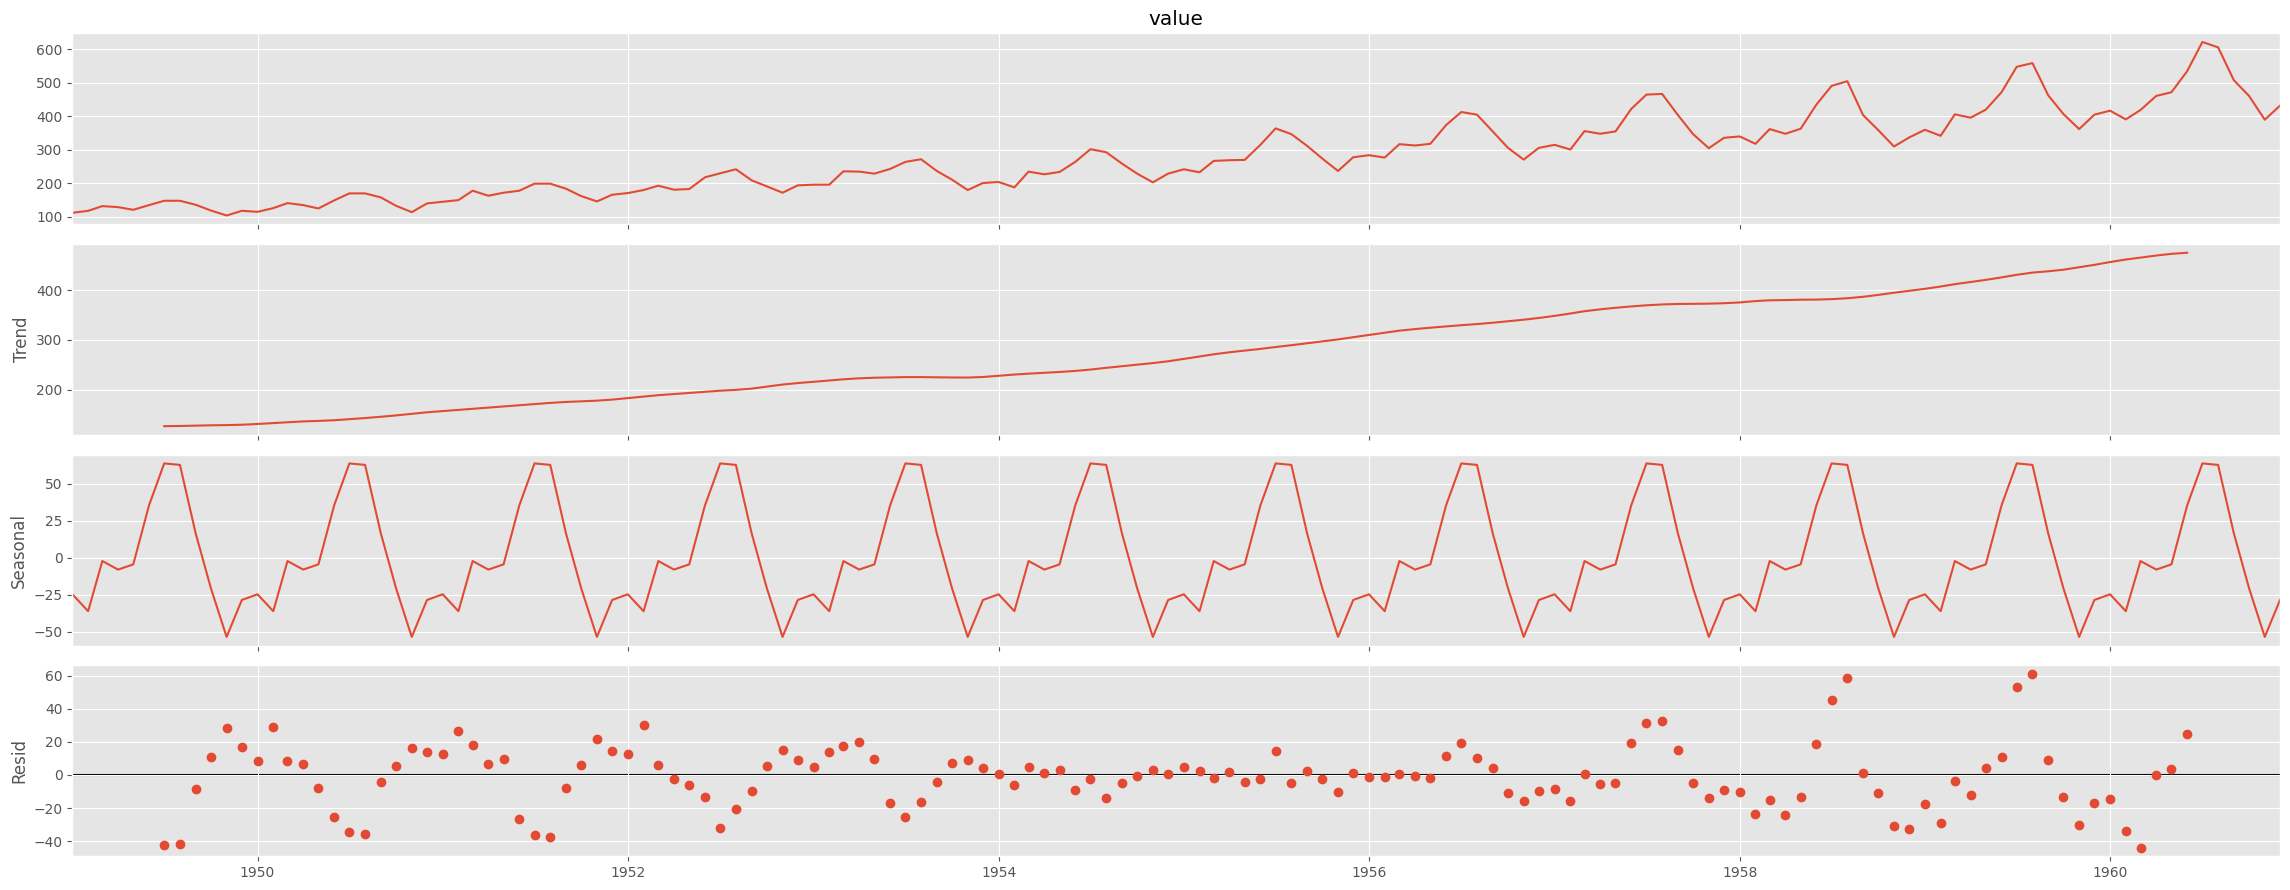

In [ ]:
sm.tsa.seasonal_decompose(data['value']).plot()
plt.show()

## **<font color='green' size=5> Prophet**

Страница Prophet  
https://github.com/facebook/prophet

Доки Prophet  
https://facebook.github.io/prophet/docs/quick_start.html

In [ ]:
df_prophet = data['value'].reset_index().copy()
df_prophet.columns = ['ds', 'y']
df_prophet.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [ ]:
train_prophet = df_prophet[:-12]
test_prophet = df_prophet[-12:]

In [ ]:

model = Prophet(seasonality_mode='additive', )

model.fit(train_prophet)
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprszb8jp1/bvuqr6mb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprszb8jp1/qu79l3w7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89733', 'data', 'file=/tmp/tmprszb8jp1/bvuqr6mb.json', 'init=/tmp/tmprszb8jp1/qu79l3w7.json', 'output', 'file=/tmp/tmprszb8jp1/prophet_modelgv_7wjwc/prophet_model-20240724172411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


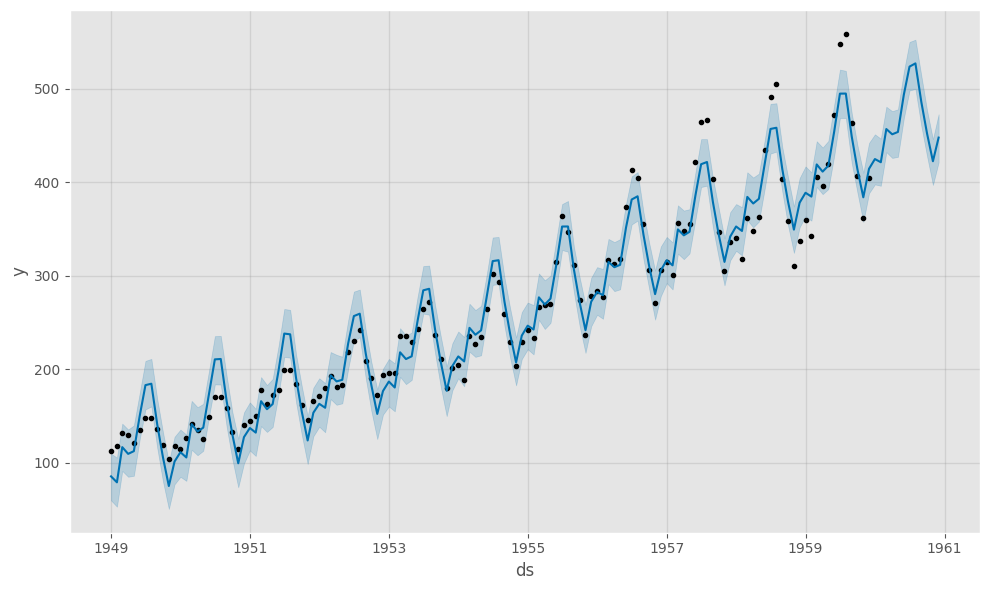

In [ ]:
ax = model.plot(forecast)

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,109.168228,59.011383,109.475619,109.168228,109.168228,-23.933652,-23.933652,-23.933652,-23.933652,-23.933652,-23.933652,0.0,0.0,0.0,85.234576
1,1949-02-01,111.321267,54.512116,103.816688,111.321267,111.321267,-32.465212,-32.465212,-32.465212,-32.465212,-32.465212,-32.465212,0.0,0.0,0.0,78.856055
2,1949-03-01,113.265948,89.196959,141.691422,113.265948,113.265948,3.272978,3.272978,3.272978,3.272978,3.272978,3.272978,0.0,0.0,0.0,116.538926
3,1949-04-01,115.418987,81.912790,135.165585,115.418987,115.418987,-6.101050,-6.101050,-6.101050,-6.101050,-6.101050,-6.101050,0.0,0.0,0.0,109.317937
4,1949-05-01,117.502573,87.802277,137.144884,117.502573,117.502573,-5.266171,-5.266171,-5.266171,-5.266171,-5.266171,-5.266171,0.0,0.0,0.0,112.236402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08-01,467.930364,501.825770,554.081338,467.662185,468.281815,59.350226,59.350226,59.350226,59.350226,59.350226,59.350226,0.0,0.0,0.0,527.280590
140,1960-09-01,470.948785,459.801204,513.450698,470.634263,471.365442,15.110553,15.110553,15.110553,15.110553,15.110553,15.110553,0.0,0.0,0.0,486.059339
141,1960-10-01,473.869838,426.307526,477.523193,473.484138,474.388278,-21.497052,-21.497052,-21.497052,-21.497052,-21.497052,-21.497052,0.0,0.0,0.0,452.372785
142,1960-11-01,476.888259,396.171676,447.634709,476.453351,477.484328,-54.341649,-54.341649,-54.341649,-54.341649,-54.341649,-54.341649,0.0,0.0,0.0,422.546610


In [ ]:
p_prediction = test_prophet.set_index('ds').join(forecast.set_index('ds')[['yhat']][-12:])
p_prediction

,y,yhat
ds,,
1960-01-01,417,424.881443
1960-02-01,391,421.489685
1960-03-01,419,457.003181
1960-04-01,461,451.394103
1960-05-01,472,453.901069
1960-06-01,535,493.715767
1960-07-01,622,523.845180
1960-08-01,606,527.280590
1960-09-01,508,486.059339


In [ ]:
mse = MSE(p_prediction['y'], p_prediction['yhat'])
print('Prophet')
print('MAPE:', MAPE(p_prediction['y'], p_prediction['yhat']))
print('RMSE:', mse**.5)
print('MSE:', mse)

Prophet
MAPE: 0.06614227312976799
RMSE: 43.06779943855511
MSE: 1854.835348479608


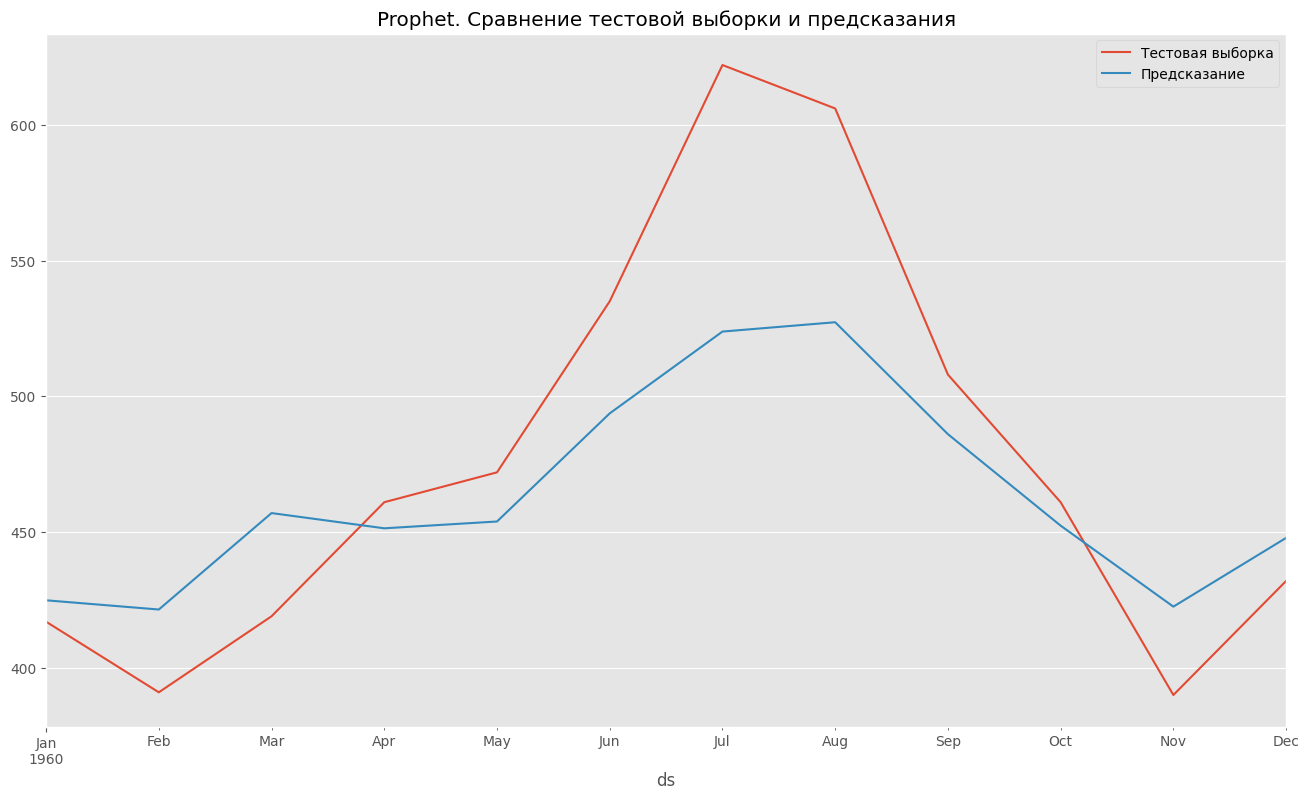

In [ ]:
ax1 = p_prediction['y'].plot(legend=True, title='Prophet. Сравнение тестовой выборки и предсказания')
ax2 = p_prediction['yhat'].plot(figsize=(16,9), legend=True) \
  .legend(['Тестовая выборка', 'Предсказание'])

In [ ]:
prediction = forecast.set_index('ds')[['yhat']]
prediction[-12:]

,yhat
ds,
1960-01-01,424.881443
1960-02-01,421.489685
1960-03-01,457.003181
1960-04-01,451.394103
1960-05-01,453.901069
1960-06-01,493.715767
1960-07-01,523.845180
1960-08-01,527.280590
1960-09-01,486.059339


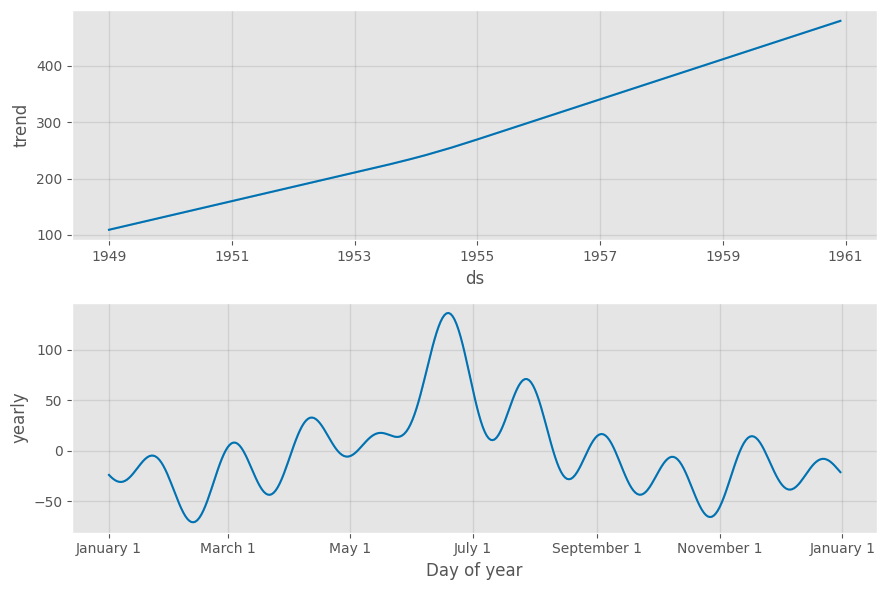

In [ ]:
fig = model.plot_components(forecast)

Change points

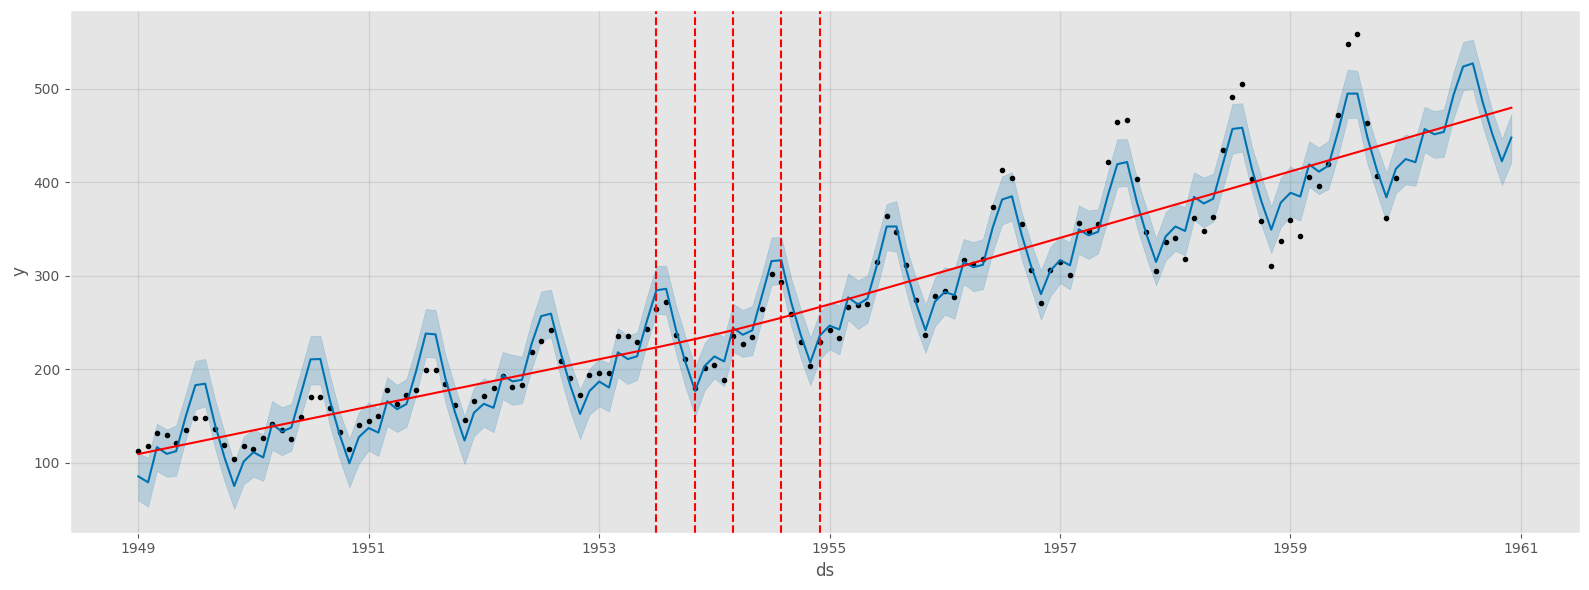

In [ ]:
fig = model.plot(forecast, figsize=(16, 6))
a = add_changepoints_to_plot(fig.gca(), model, forecast)


In [ ]:
model.changepoints

4     1949-05-01
8     1949-09-01
12    1950-01-01
17    1950-06-01
21    1950-10-01
25    1951-02-01
29    1951-06-01
33    1951-10-01
37    1952-02-01
42    1952-07-01
46    1952-11-01
50    1953-03-01
54    1953-07-01
58    1953-11-01
62    1954-03-01
67    1954-08-01
71    1954-12-01
75    1955-04-01
79    1955-08-01
83    1955-12-01
87    1956-04-01
92    1956-09-01
96    1957-01-01
100   1957-05-01
104   1957-09-01
Name: ds, dtype: datetime64[ns]

In [ ]:
model = Prophet()
model.add_country_holidays(country_name='US')
model.fit(train_prophet)

future = model.make_future_dataframe(periods=test_size)
forecast = model.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprszb8jp1/t4z4egzo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprszb8jp1/4u_ks39k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19652', 'data', 'file=/tmp/tmprszb8jp1/t4z4egzo.json', 'init=/tmp/tmprszb8jp1/4u_ks39k.json', 'output', 'file=/tmp/tmprszb8jp1/prophet_modellrow6mat/prophet_model-20240724154243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


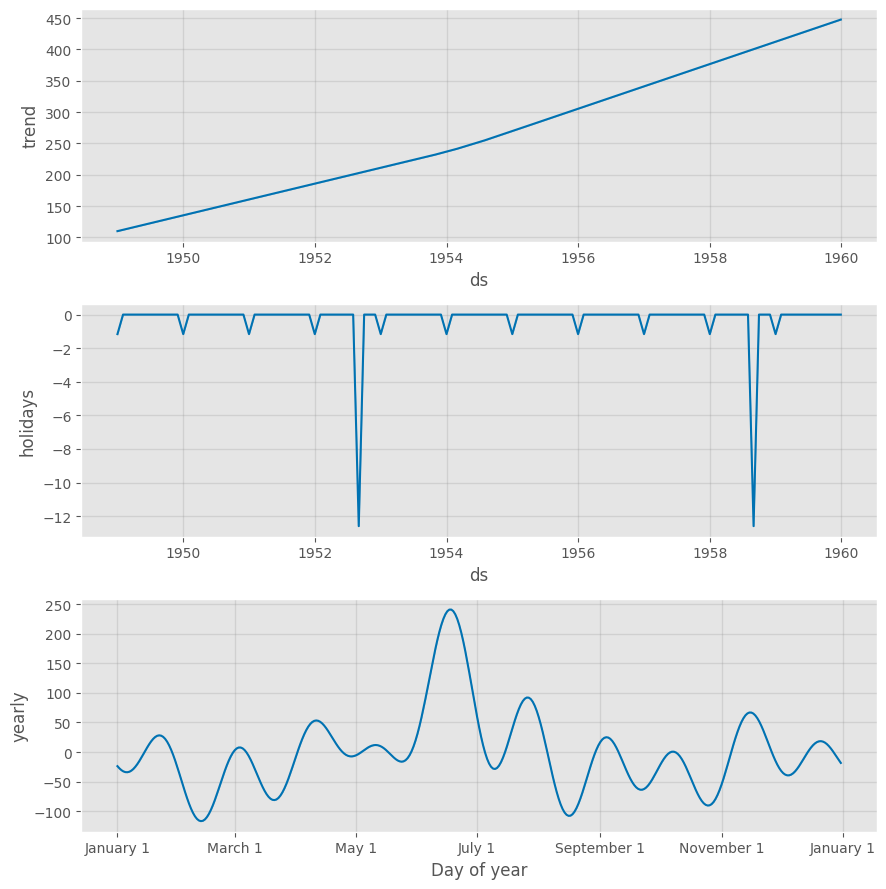

In [ ]:
fig = model.plot_components(forecast)